# Import libraries

In [46]:
import random
# random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math
import pickle

# from pytorch_metric_learning import losses, miners, distances, reducers, testers
# from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Representation function def

In [47]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

def visualize_embedding(features, labels, label_dict=None, save_path=None):
    if label_dict is None:
        str_labels = labels
    else:
        str_labels = [label_dict[k] for k in labels]

    tsne_features = TSNE(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], 
                    hue=str_labels, style=str_labels, palette="deep")

    if save_path is not None:
        fig.savefig(save_path)

    return fig, tsne_features


def visualize_cm(cm, save_path=None, str_labels=None):
    
    fig, ax = plt.subplots(figsize=(15,10))
    xticklabels = str_labels if str_labels is not None else 'auto'
    yticklabels = str_labels if str_labels is not None else 'auto'
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

    if save_path is not None:
        fig.savefig(save_path)

    return fig

# FERDataset

In [48]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [49]:
batch_size= 64

# df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')
df = pd.read_csv('../../../data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

# train_set = FERDataset(df_train, train_transforms)
train_set = FERDataset(df_train, train_transforms) # no augmentation!
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

<ipython-input-48-cc86490abb55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]


# Define model

## sVGG

In [18]:
from torchvision.models import vgg16_bn

In [19]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sim_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

## Resnet50

In [57]:
class Resnet50_exp(nn.Module):
    def __init__(self, sample_model, in_features_classifier=2048, n_classes=100):
        super(Resnet50_exp, self).__init__()
        
#         self.conv1 = sample_model.conv1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = sample_model.bn1
        self.relu = sample_model.relu
        self.maxpool = sample_model.maxpool
        
        self.layer1 = sample_model.layer1
        self.layer2 = sample_model.layer2
        self.layer3 = sample_model.layer3
        self.layer4 = sample_model.layer4
        
        self.avgpool = sample_model.avgpool
        
        self.exploss = ExpLoss(in_features_classifier, residual=True)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, n_classes))
                                        
    def forward(self, x, labels, return_att=True):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        att, sim_loss = self.exploss(x, labels)

        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

## Exploss with custom simloss

In [58]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        
#         if labels is not None:
#             mask = self.filter_mask(labels)
#             att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         else:
        att_mask = torch.where(sims.sigmoid() >= 0.5, 1, 0)
        att = sims * (att_mask.to(sims.device))
        
#         print(att_mask)
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        mask = self.filter_mask(labels)
        same_att = sims.sigmoid() * (1 - mask.to(sims.device))
        same_att = same_att[same_att != 0]
        
        opst_att = sims.sigmoid() * mask.to(sims.device) # the opposite att contaning samples with different labels
        opst_att = opst_att[opst_att != 0] if len(opst_att[opst_att != 0]) > 0 else torch.tensor([0.])            
        
        same_sims = -torch.log(1 - same_att + EPS).mean()
        opst_sims = -torch.log(opst_att + EPS).mean()

        sim_loss = same_sims + opst_sims
        
        return x, sim_loss

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [39]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [59]:
model = Resnet50_exp(sample_model=models.resnet50(pretrained=False), in_features_classifier=2048, n_classes=7)

In [60]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [61]:
model_path = 'newexp/resnewexp_resnet50_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sim_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=nan Simloss=nan Batch_id=59 Accuracy=0.2265625:  27%|██▋       | 60/225 [00:06<00:18,  9.11it/s]                          


KeyboardInterrupt: 

In [41]:
model_path = 'newexp/resnewexp_vgg16_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sim_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=3.2970051765441895 Simloss=1.3802483081817627 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:18<00:00, 23.97it/s]

- Avg.loss: 3.2438 | Avg.acc: 0.2458


- Avg. test_loss: 3.2002 | Avg. test_acc: 0.2516


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=2.973874568939209 Simloss=1.3257745504379272 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.88it/s]

- Avg.loss: 3.1523 | Avg.acc: 0.2664


- Avg. test_loss: 3.1907 | Avg. test_acc: 0.2889


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=2.8690357208251953 Simloss=1.269222378730774 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:18<00:00, 23.84it/s]

- Avg.loss: 2.8506 | Avg.acc: 0.3779


- Avg. test_loss: 2.9049 | Avg. test_acc: 0.3522


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=3.2417712211608887 Simloss=1.6901218891143799 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:18<00:00, 23.78it/s]

- Avg.loss: 2.6003 | Avg.acc: 0.4341


- Avg. test_loss: 2.5518 | Avg. test_acc: 0.4550


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=3.218503713607788 Simloss=1.6701054573059082 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:18<00:00, 23.77it/s]

- Avg.loss: 2.4754 | Avg.acc: 0.4684


- Avg. test_loss: 2.4191 | Avg. test_acc: 0.4960


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=2.3024251461029053 Simloss=1.0572788715362549 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.77it/s]

- Avg.loss: 2.3826 | Avg.acc: 0.4986


- Avg. test_loss: 2.3870 | Avg. test_acc: 0.5088


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=2.448688507080078 Simloss=1.1787691116333008 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 2.2959 | Avg.acc: 0.5231



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.5106 | Avg. test_acc: 0.4695
Epoch:  8


Loss=2.438507556915283 Simloss=1.1761622428894043 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:18<00:00, 23.78it/s]

- Avg.loss: 2.2096 | Avg.acc: 0.5470


- Avg. test_loss: 2.4503 | Avg. test_acc: 0.5104


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=2.5055437088012695 Simloss=1.303962230682373 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 23.73it/s]

- Avg.loss: 2.1340 | Avg.acc: 0.5653


- Avg. test_loss: 2.3732 | Avg. test_acc: 0.5216


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=3.105769634246826 Simloss=1.6165581941604614 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.67it/s]

- Avg.loss: 2.0528 | Avg.acc: 0.5902


- Avg. test_loss: 2.3018 | Avg. test_acc: 0.5559


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.6462687253952026 Simloss=0.8178281784057617 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:18<00:00, 23.76it/s]

- Avg.loss: 1.9594 | Avg.acc: 0.6095


- Avg. test_loss: 2.2879 | Avg. test_acc: 0.5709


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=2.1801598072052 Simloss=1.1357192993164062 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 23.70it/s]

- Avg.loss: 1.8826 | Avg.acc: 0.6297


- Avg. test_loss: 2.2281 | Avg. test_acc: 0.5846


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.8928799629211426 Simloss=0.8936188220977783 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:18<00:00, 23.68it/s]

- Avg.loss: 1.7842 | Avg.acc: 0.6551


- Avg. test_loss: 2.1623 | Avg. test_acc: 0.5960


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.4519670009613037 Simloss=0.6861355304718018 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 23.68it/s]

- Avg.loss: 1.6883 | Avg.acc: 0.6762



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3239 | Avg. test_acc: 0.5840
Epoch:  15


Loss=2.275454044342041 Simloss=1.1882624626159668 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]

- Avg.loss: 1.5958 | Avg.acc: 0.7010


- Avg. test_loss: 2.2464 | Avg. test_acc: 0.5977


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.323735237121582 Simloss=0.5413525104522705 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 23.68it/s]

- Avg.loss: 1.4871 | Avg.acc: 0.7263



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3745 | Avg. test_acc: 0.5821
Epoch:  17


Loss=1.3697412014007568 Simloss=0.7030961513519287 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 23.71it/s]

- Avg.loss: 1.3792 | Avg.acc: 0.7477



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.5956 | Avg. test_acc: 0.5949
Epoch:  18


Loss=1.391703486442566 Simloss=0.6678564548492432 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 1.2893 | Avg.acc: 0.7688



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.6420 | Avg. test_acc: 0.5500
Epoch:  19


Loss=1.060847282409668 Simloss=0.5318009257316589 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 23.76it/s]

- Avg.loss: 1.1800 | Avg.acc: 0.7932


- Avg. test_loss: 2.7198 | Avg. test_acc: 0.6032
Epoch    19: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.6528819799423218 Simloss=0.21720623970031738 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:18<00:00, 23.73it/s]

- Avg.loss: 0.8249 | Avg.acc: 0.8640


- Avg. test_loss: 2.8443 | Avg. test_acc: 0.6297


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=1.1551694869995117 Simloss=0.6322869062423706 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]

- Avg.loss: 0.6673 | Avg.acc: 0.8943



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.2314 | Avg. test_acc: 0.6247
Epoch:  22


Loss=0.7383757829666138 Simloss=0.417619913816452 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.75it/s]

- Avg.loss: 0.5673 | Avg.acc: 0.9131



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.4431 | Avg. test_acc: 0.6230
Epoch:  23


Loss=0.8780107498168945 Simloss=0.54891037940979 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]

- Avg.loss: 0.4830 | Avg.acc: 0.9289



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.8966 | Avg. test_acc: 0.6266
Epoch:  24


Loss=0.3721000850200653 Simloss=0.22759512066841125 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.78it/s]

- Avg.loss: 0.4088 | Avg.acc: 0.9421



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 4.2410 | Avg. test_acc: 0.6199
Epoch:  25


Loss=0.7094439268112183 Simloss=0.43568527698516846 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 0.3405 | Avg.acc: 0.9520



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 4.5302 | Avg. test_acc: 0.6205
Epoch    25: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  26


Loss=0.8520832657814026 Simloss=0.5446469187736511 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 23.73it/s]

- Avg.loss: 0.2697 | Avg.acc: 0.9614



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 4.6896 | Avg. test_acc: 0.6278
Epoch:  27


Loss=0.27721917629241943 Simloss=0.16605855524539948 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 23.73it/s]      

- Avg.loss: 0.2557 | Avg.acc: 0.9638



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 4.8601 | Avg. test_acc: 0.6222
Epoch:  28


Loss=0.22867760062217712 Simloss=0.1383364200592041 Batch_id=39 Accuracy=0.953125:   9%|▉         | 40/449 [00:02<00:22, 18.48it/s] 


KeyboardInterrupt: 

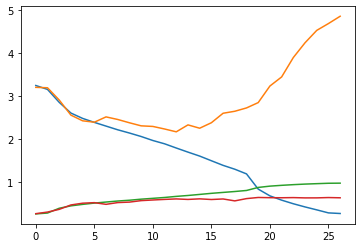

In [42]:
plt.plot(hist)

In [43]:
model = torch.load('newexp/resnewexp_vgg16_model.pt')
model.eval()

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sim_loss, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels) + sim_loss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

- Avg. test_loss: 2.5361 | Avg. test_acc: 0.6383


In [44]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[ -3.407057 ,  41.0064   ],
        [  5.3977427,  -1.9358922],
        [ 38.97093  ,  25.425547 ],
        ...,
        [ 24.475235 , -18.137947 ],
        [-14.395163 , -23.354813 ],
        [ -2.161438 ,  29.68049  ]], dtype=float32))

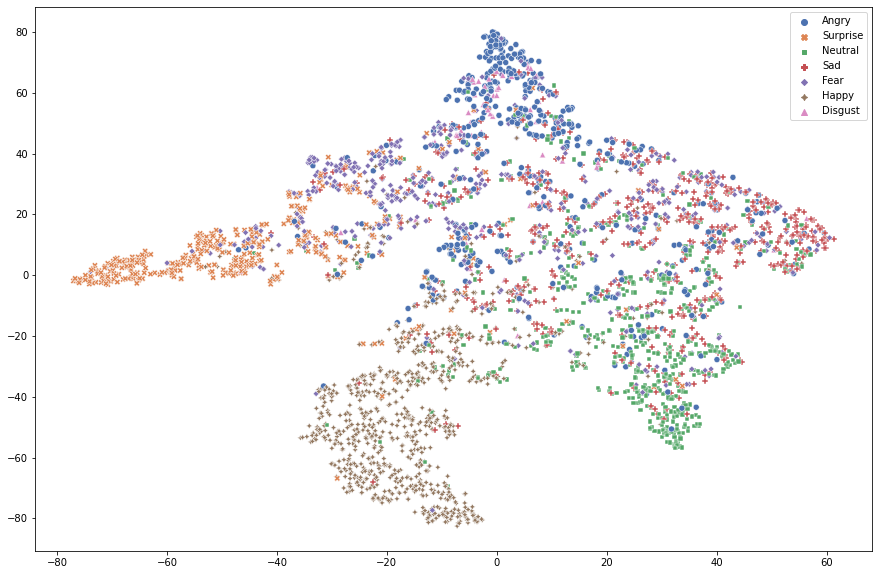

In [45]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

## Exploss | simloss as a binary classification (same vs. different class)

sample labels: 1  
different labels: 0

In [6]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        self.fc2 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x = self.dropout(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        
#         att_mask = torch.where(sims.sigmoid() >= 0.5, 1, 0)
#         att = sims * (att_mask.to(att_mask.device))
#         att = sims.sigmoid()

#         att = self.relu(sims * (torch.eye(len(sims)).to(sims.device)))
        att = sims
        
#         print(att_mask)
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        mask_labels = self.filter_mask(labels)
        mask_labels = 1 - mask_labels # same labels as 1, different labels as 0
        mask_labels = mask_labels.to(labels.device)
        
        return x, sims, mask_labels # sims.sigmoid() and mask_labels are used to cal BCELoss

    def filter_mask(self, labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [7]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sims, sims_labels = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sims, sims_labels, att
        return x, sims, sims_labels
        

In [73]:
class Resnet50_exp(nn.Module):
    def __init__(self, sample_model, in_features_classifier=2048, n_classes=100):
        super(Resnet50_exp, self).__init__()
        
#         self.conv1 = sample_model.conv1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = sample_model.bn1
        self.relu = sample_model.relu
        self.maxpool = sample_model.maxpool
        
        self.layer1 = sample_model.layer1
        self.layer2 = sample_model.layer2
        self.layer3 = sample_model.layer3
        self.layer4 = sample_model.layer4
        
        self.avgpool = sample_model.avgpool
        
        self.exploss = ExpLoss(in_features_classifier, residual=True)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, n_classes))
                                        
    def forward(self, x, labels, return_att=True):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        att, sims, sims_labels = self.exploss(x, labels)

        x = self.classifier(att)
        
        if return_att:
            return x, sims, sims_labels, att
        return x, sims, sims_labels
        

In [9]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [57]:
model = Resnet50_exp(sample_model=models.resnet50(pretrained=False), in_features_classifier=2048, n_classes=7)

In [10]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
sims_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [24]:
model_path = 'newexp/resnewexp_binarysimsloss_svgg16_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features = model(inputs, labels)
        
        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features = model(inputs, labels)

        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=2.024430990219116 Simloss=0.48043105006217957 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:18<00:00, 24.62it/s]

- Avg.loss: 2.4611 | Avg.sims_loss: 0.6680 |Avg.acc: 0.2592


- Avg. test_loss: 2.2788 | Avg. test_sims_loss: 0.560869 | Avg. test_acc: 0.3023


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.8757603168487549 Simloss=0.4767850339412689 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 24.49it/s]

- Avg.loss: 2.0579 | Avg.sims_loss: 0.4648 |Avg.acc: 0.3602


- Avg. test_loss: 2.0071 | Avg. test_sims_loss: 0.446317 | Avg. test_acc: 0.3890


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=2.0449323654174805 Simloss=0.45910146832466125 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:18<00:00, 24.42it/s]

- Avg.loss: 1.8301 | Avg.sims_loss: 0.4165 |Avg.acc: 0.4321


- Avg. test_loss: 1.8591 | Avg. test_sims_loss: 0.464798 | Avg. test_acc: 0.4294


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.5772650241851807 Simloss=0.3812239170074463 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:18<00:00, 24.37it/s]

- Avg.loss: 1.7444 | Avg.sims_loss: 0.3992 |Avg.acc: 0.4544


- Avg. test_loss: 1.7653 | Avg. test_sims_loss: 0.412463 | Avg. test_acc: 0.4603


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.7061034440994263 Simloss=0.4342591464519501 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 24.34it/s]

- Avg.loss: 1.6990 | Avg.sims_loss: 0.3926 |Avg.acc: 0.4652


- Avg. test_loss: 1.7316 | Avg. test_sims_loss: 0.413223 | Avg. test_acc: 0.4659


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.720770239830017 Simloss=0.46117961406707764 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:18<00:00, 24.31it/s]

- Avg.loss: 1.6302 | Avg.sims_loss: 0.3815 |Avg.acc: 0.5056


- Avg. test_loss: 1.8110 | Avg. test_sims_loss: 0.425065 | Avg. test_acc: 0.4739


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.7602359056472778 Simloss=0.630165696144104 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:18<00:00, 24.30it/s]

- Avg.loss: 1.5643 | Avg.sims_loss: 0.3710 |Avg.acc: 0.5400



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6409 | Avg. test_sims_loss: 0.399634 | Avg. test_acc: 0.5428
* Update optimal model
Epoch:  8


Loss=1.919957160949707 Simloss=0.4593260884284973 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:18<00:00, 24.33it/s]

- Avg.loss: 1.5012 | Avg.sims_loss: 0.3617 |Avg.acc: 0.5672


- Avg. test_loss: 1.5485 | Avg. test_sims_loss: 0.384668 | Avg. test_acc: 0.5559


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.6473058462142944 Simloss=0.45433440804481506 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 24.30it/s]

- Avg.loss: 1.4426 | Avg.sims_loss: 0.3526 |Avg.acc: 0.5871



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5897 | Avg. test_sims_loss: 0.388092 | Avg. test_acc: 0.5500
Epoch:  10


Loss=1.558171272277832 Simloss=0.37534046173095703 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 24.39it/s]

- Avg.loss: 1.3859 | Avg.sims_loss: 0.3430 |Avg.acc: 0.6100


- Avg. test_loss: 1.5650 | Avg. test_sims_loss: 0.388536 | Avg. test_acc: 0.5637


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.2042806148529053 Simloss=0.30833297967910767 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.24it/s]

- Avg.loss: 1.3238 | Avg.sims_loss: 0.3320 |Avg.acc: 0.6358


- Avg. test_loss: 1.5200 | Avg. test_sims_loss: 0.395700 | Avg. test_acc: 0.5926


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.394615888595581 Simloss=0.4201844334602356 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 24.32it/s]

- Avg.loss: 1.2558 | Avg.sims_loss: 0.3189 |Avg.acc: 0.6564


- Avg. test_loss: 1.4702 | Avg. test_sims_loss: 0.371361 | Avg. test_acc: 0.5932


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.8016304969787598 Simloss=0.5012236833572388 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.20it/s]

- Avg.loss: 1.1878 | Avg.sims_loss: 0.3054 |Avg.acc: 0.6825



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5511 | Avg. test_sims_loss: 0.378114 | Avg. test_acc: 0.5821
Epoch:  14


Loss=0.9456056356430054 Simloss=0.2769785225391388 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:18<00:00, 24.30it/s]

- Avg.loss: 1.1170 | Avg.sims_loss: 0.2920 |Avg.acc: 0.7034



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5580 | Avg. test_sims_loss: 0.405284 | Avg. test_acc: 0.5882
Epoch:  15


Loss=1.2311995029449463 Simloss=0.3776291310787201 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.33it/s]

- Avg.loss: 1.0431 | Avg.sims_loss: 0.2759 |Avg.acc: 0.7293



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6638 | Avg. test_sims_loss: 0.420306 | Avg. test_acc: 0.5701
Epoch:  16


Loss=0.7758450508117676 Simloss=0.2286430299282074 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:18<00:00, 24.34it/s]

- Avg.loss: 0.9646 | Avg.sims_loss: 0.2603 |Avg.acc: 0.7545



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6232 | Avg. test_sims_loss: 0.387015 | Avg. test_acc: 0.5759
Epoch:  17


Loss=1.0991672277450562 Simloss=0.27980995178222656 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.29it/s]

- Avg.loss: 0.9015 | Avg.sims_loss: 0.2488 |Avg.acc: 0.7770


- Avg. test_loss: 1.5860 | Avg. test_sims_loss: 0.391890 | Avg. test_acc: 0.6027


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=0.8399245738983154 Simloss=0.26233652234077454 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:18<00:00, 24.26it/s]

- Avg.loss: 0.8189 | Avg.sims_loss: 0.2304 |Avg.acc: 0.7978



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.8331 | Avg. test_sims_loss: 0.402900 | Avg. test_acc: 0.5921
Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  19


Loss=0.49110519886016846 Simloss=0.13135062158107758 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:18<00:00, 24.30it/s]

- Avg.loss: 0.5541 | Avg.sims_loss: 0.1742 |Avg.acc: 0.8746


- Avg. test_loss: 1.7880 | Avg. test_sims_loss: 0.383341 | Avg. test_acc: 0.6303


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.5751285552978516 Simloss=0.18470853567123413 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:18<00:00, 24.27it/s]

- Avg.loss: 0.4444 | Avg.sims_loss: 0.1481 |Avg.acc: 0.9043



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.9086 | Avg. test_sims_loss: 0.392235 | Avg. test_acc: 0.6275
Epoch:  21


Loss=0.44661328196525574 Simloss=0.09246569871902466 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.37it/s]

- Avg.loss: 0.3801 | Avg.sims_loss: 0.1313 |Avg.acc: 0.9205



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.0831 | Avg. test_sims_loss: 0.408240 | Avg. test_acc: 0.6294
Epoch:  22


Loss=0.17644059658050537 Simloss=0.07477375119924545 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.28it/s]

- Avg.loss: 0.3206 | Avg.sims_loss: 0.1151 |Avg.acc: 0.9357



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2369 | Avg. test_sims_loss: 0.417804 | Avg. test_acc: 0.6250
Epoch:  23


Loss=0.11310422420501709 Simloss=0.04403418302536011 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.35it/s]     

- Avg.loss: 0.2775 | Avg.sims_loss: 0.1023 |Avg.acc: 0.9443



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3868 | Avg. test_sims_loss: 0.432204 | Avg. test_acc: 0.6239
Epoch:  24


Loss=0.9238316416740417 Simloss=0.3030242323875427 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:18<00:00, 24.36it/s]

- Avg.loss: 0.2414 | Avg.sims_loss: 0.0908 |Avg.acc: 0.9544



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.4401 | Avg. test_sims_loss: 0.444659 | Avg. test_acc: 0.6252
Epoch    24: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  25


Loss=0.15727774798870087 Simloss=0.031736236065626144 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 24.30it/s]

- Avg.loss: 0.1997 | Avg.sims_loss: 0.0782 |Avg.acc: 0.9647



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.4684 | Avg. test_sims_loss: 0.442009 | Avg. test_acc: 0.6222
Epoch:  26


Loss=0.16341300308704376 Simloss=0.04244953393936157 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.19it/s]

- Avg.loss: 0.1893 | Avg.sims_loss: 0.0753 |Avg.acc: 0.9658



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.5027 | Avg. test_sims_loss: 0.443232 | Avg. test_acc: 0.6216
Epoch:  27


Loss=0.28069406747817993 Simloss=0.12339173257350922 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:18<00:00, 24.29it/s]

- Avg.loss: 0.1834 | Avg.sims_loss: 0.0739 |Avg.acc: 0.9685



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.5778 | Avg. test_sims_loss: 0.450647 | Avg. test_acc: 0.6230
Epoch:  28


Loss=0.16670076549053192 Simloss=0.03384467586874962 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.30it/s]

- Avg.loss: 0.1738 | Avg.sims_loss: 0.0712 |Avg.acc: 0.9704



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.6019 | Avg. test_sims_loss: 0.454380 | Avg. test_acc: 0.6216
Epoch:  29


Loss=0.035868559032678604 Simloss=0.010801250115036964 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.34it/s]    

- Avg.loss: 0.1687 | Avg.sims_loss: 0.0698 |Avg.acc: 0.9709



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.6405 | Avg. test_sims_loss: 0.456743 | Avg. test_acc: 0.6191
Epoch:  30


Loss=0.15130802989006042 Simloss=0.05183814465999603 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:18<00:00, 24.31it/s]

- Avg.loss: 0.1638 | Avg.sims_loss: 0.0684 |Avg.acc: 0.9716



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.7011 | Avg. test_sims_loss: 0.453280 | Avg. test_acc: 0.6250
Epoch    30: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  31


Loss=0.11435338109731674 Simloss=0.05833135545253754 Batch_id=214 Accuracy=0.984375:  48%|████▊     | 215/449 [00:09<00:09, 23.52it/s] 


KeyboardInterrupt: 

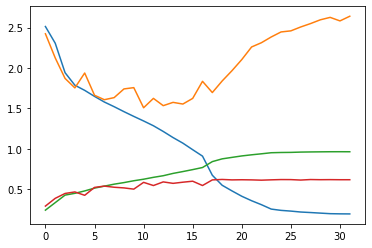

In [110]:
plt.plot(hist)

In [26]:
model = torch.load('newexp/resnewexp_binarysimsloss_svgg16_model.pt')
exp_features = []
exp_labels = []

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sims, sims_labels, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    sims_loss = sims_criterion(sims, sims_labels)
    loss = criterion(outputs, labels) + sims_loss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. test_loss: 1.6683 | Avg. test_acc: 0.6395


In [27]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[-43.649967 ,   4.583399 ],
        [-16.201998 , -11.265834 ],
        [ -7.9630914,  13.692518 ],
        ...,
        [ 19.748373 , -12.897928 ],
        [ 20.560366 ,  55.347363 ],
        [-13.89733  ,  12.350405 ]], dtype=float32))

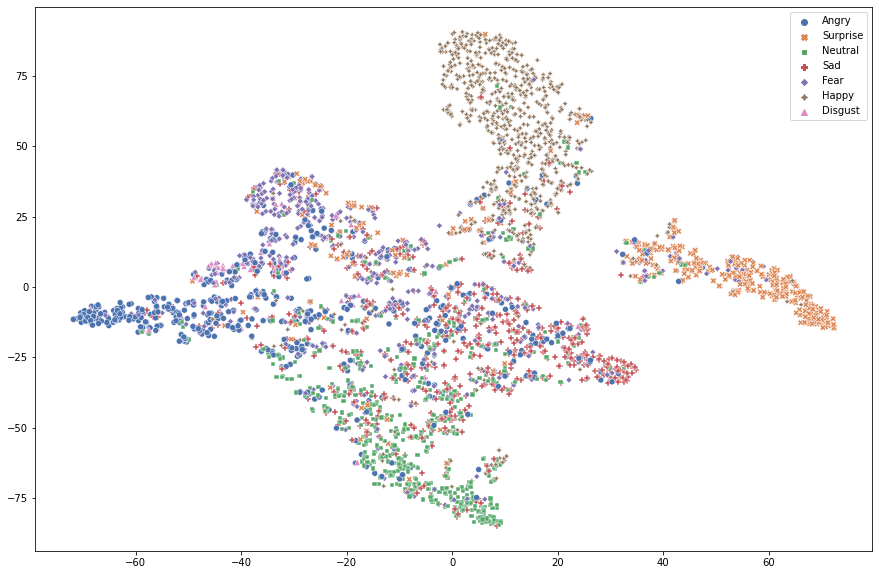

In [85]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

(<Figure size 1080x720 with 1 Axes>,
 array([[ -1.5107219 ,   4.7096334 ],
        [ -4.3755198 , -19.283026  ],
        [ -3.123462  , -33.68542   ],
        ...,
        [  3.30624   ,  -6.582691  ],
        [  1.401317  ,  35.484566  ],
        [-26.591396  ,   0.90599525]], dtype=float32))

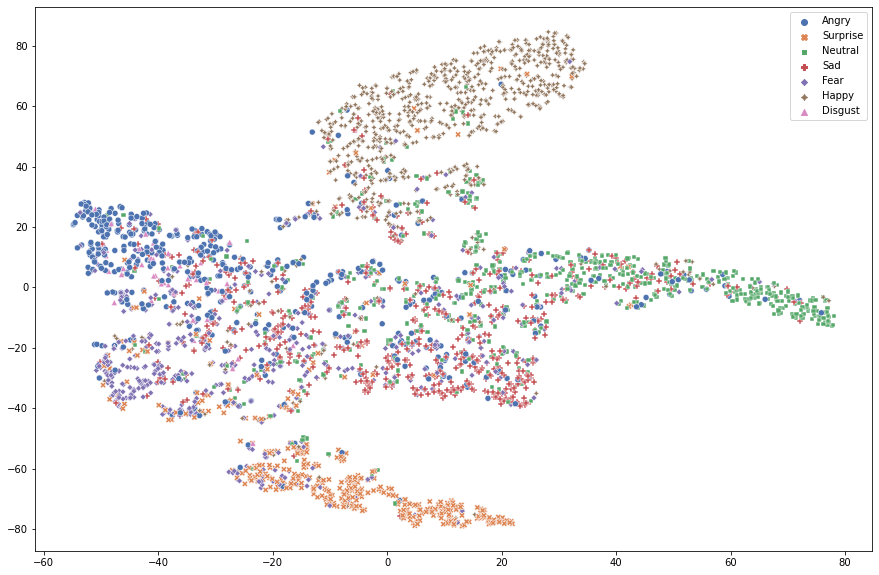

In [104]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

(<Figure size 1080x720 with 1 Axes>,
 array([[-21.898382 , -48.285862 ],
        [-11.584171 ,   5.047659 ],
        [-26.787056 , -26.079563 ],
        ...,
        [-29.212715 ,   6.7437196],
        [  7.9507604,   1.4798439],
        [-39.86646  ,  -8.196867 ]], dtype=float32))

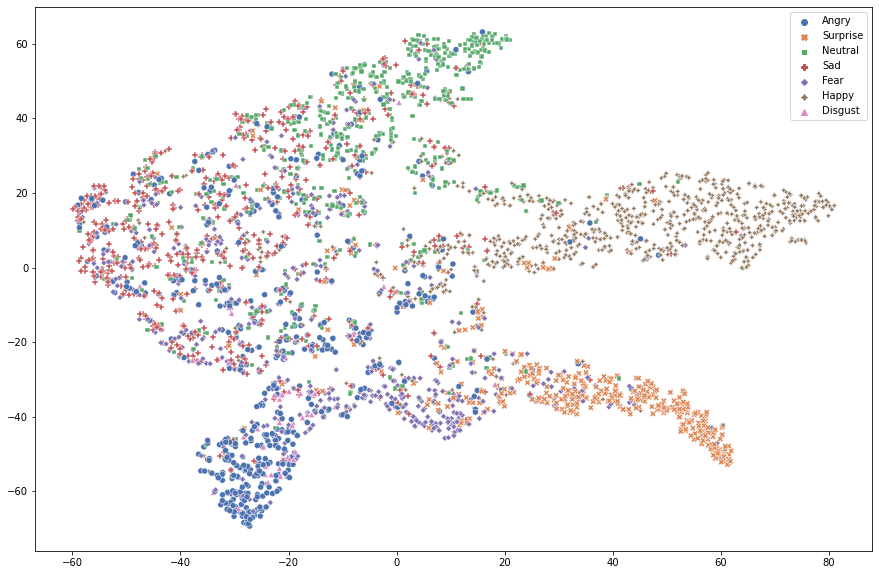

In [113]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

(<Figure size 1080x720 with 1 Axes>,
 array([[-16.277029 , -39.910496 ],
        [ -2.2641807,  -4.3166122],
        [-41.850235 , -28.614046 ],
        ...,
        [ 22.191404 , -33.174923 ],
        [ 34.081226 ,  69.06562  ],
        [-40.649437 , -26.149544 ]], dtype=float32))

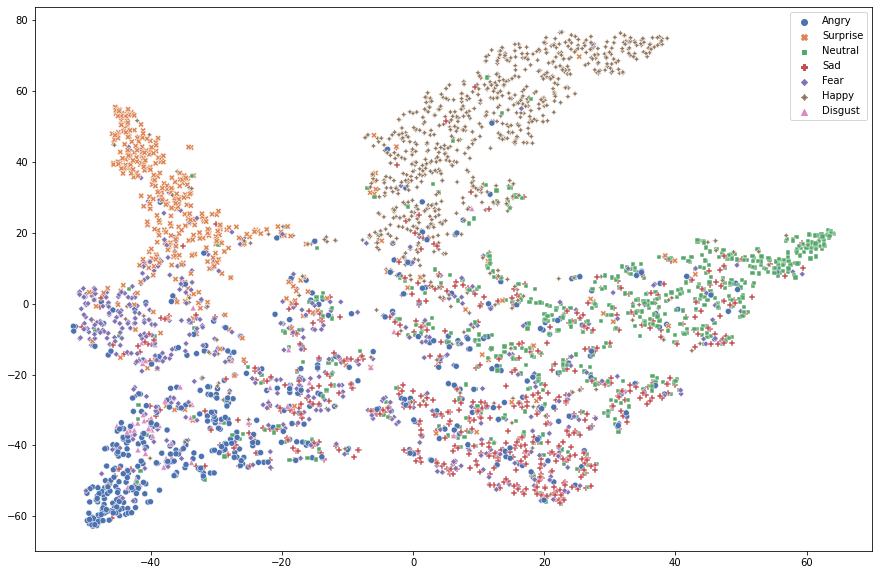

In [28]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

In [ ]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        self.fc2 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x = self.dropout(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        
        att_mask = torch.where(sims.sigmoid() >= 0.5, 1, 0)
#         att = sims * (att_mask.to(att_mask.device))
#         att = sims.sigmoid()

#         att = self.relu(sims * (torch.eye(len(sims)).to(sims.device)))
        att = sims
        
#         print(att_mask)
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        mask_labels = self.filter_mask(labels)
        mask_labels = 1 - mask_labels # same labels as 1, different labels as 0
        mask_labels = mask_labels.to(labels.device)
        
        return x, sims, mask_labels # sims.sigmoid() and mask_labels are used to cal BCELoss

    def filter_mask(self, labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [12]:
model_path = 'newexp/dataaug_resnewexp_binarysimsloss_svgg16_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features = model(inputs, labels)
        
        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features = model(inputs, labels)

        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=2.137136697769165 Simloss=0.5143221616744995 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:18<00:00, 24.37it/s]

- Avg.loss: 2.4730 | Avg.sims_loss: 0.6619 |Avg.acc: 0.2516



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2543 | Avg. test_sims_loss: 0.522918 | Avg. test_acc: 0.2965
* Update optimal model
Epoch:  2


Loss=1.8408212661743164 Simloss=0.47858351469039917 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:18<00:00, 24.40it/s]

- Avg.loss: 2.1756 | Avg.sims_loss: 0.4774 |Avg.acc: 0.3082


- Avg. test_loss: 1.9978 | Avg. test_sims_loss: 0.466707 | Avg. test_acc: 0.3759


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.792048692703247 Simloss=0.5076229572296143 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 24.24it/s]

- Avg.loss: 1.9964 | Avg.sims_loss: 0.4495 |Avg.acc: 0.3804



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.8494 | Avg. test_sims_loss: 0.816103 | Avg. test_acc: 0.3182
Epoch:  4


Loss=1.981877326965332 Simloss=0.6206838488578796 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 24.32it/s]

- Avg.loss: 1.8561 | Avg.sims_loss: 0.4248 |Avg.acc: 0.4325


- Avg. test_loss: 1.8259 | Avg. test_sims_loss: 0.429268 | Avg. test_acc: 0.4706


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.7927632331848145 Simloss=0.5670443177223206 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:18<00:00, 24.25it/s]

- Avg.loss: 1.7937 | Avg.sims_loss: 0.4140 |Avg.acc: 0.4494



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.8627 | Avg. test_sims_loss: 0.427396 | Avg. test_acc: 0.4216
Epoch:  6


Loss=2.096930503845215 Simloss=0.5304945707321167 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:18<00:00, 24.17it/s]

- Avg.loss: 1.7532 | Avg.sims_loss: 0.4058 |Avg.acc: 0.4720


- Avg. test_loss: 1.7355 | Avg. test_sims_loss: 0.415850 | Avg. test_acc: 0.4901


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.796020269393921 Simloss=0.49994829297065735 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 24.14it/s]

- Avg.loss: 1.7108 | Avg.sims_loss: 0.4003 |Avg.acc: 0.4944



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.8334 | Avg. test_sims_loss: 0.481320 | Avg. test_acc: 0.4787
Epoch:  8


Loss=1.757476806640625 Simloss=0.5100985169410706 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 24.30it/s]

- Avg.loss: 1.6549 | Avg.sims_loss: 0.3920 |Avg.acc: 0.5148


- Avg. test_loss: 1.6461 | Avg. test_sims_loss: 0.422287 | Avg. test_acc: 0.5277


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.793609380722046 Simloss=0.5665819048881531 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 24.00it/s]

- Avg.loss: 1.5975 | Avg.sims_loss: 0.3842 |Avg.acc: 0.5401


- Avg. test_loss: 1.6025 | Avg. test_sims_loss: 0.400363 | Avg. test_acc: 0.5492


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.229985237121582 Simloss=0.25801587104797363 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 24.05it/s]

- Avg.loss: 1.5606 | Avg.sims_loss: 0.3777 |Avg.acc: 0.5557


- Avg. test_loss: 1.5649 | Avg. test_sims_loss: 0.395546 | Avg. test_acc: 0.5567


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.9035590887069702 Simloss=0.47656819224357605 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 24.10it/s]

- Avg.loss: 1.5205 | Avg.sims_loss: 0.3745 |Avg.acc: 0.5717


- Avg. test_loss: 1.5185 | Avg. test_sims_loss: 0.384337 | Avg. test_acc: 0.5787


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.4049562215805054 Simloss=0.40895286202430725 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 24.13it/s]

- Avg.loss: 1.4813 | Avg.sims_loss: 0.3685 |Avg.acc: 0.5844



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5330 | Avg. test_sims_loss: 0.388921 | Avg. test_acc: 0.5720
Epoch:  13


Loss=1.2402653694152832 Simloss=0.39820513129234314 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.10it/s]

- Avg.loss: 1.4567 | Avg.sims_loss: 0.3651 |Avg.acc: 0.5951


- Avg. test_loss: 1.5339 | Avg. test_sims_loss: 0.413074 | Avg. test_acc: 0.5804


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.6201521158218384 Simloss=0.4723012149333954 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 24.07it/s]

- Avg.loss: 1.4310 | Avg.sims_loss: 0.3605 |Avg.acc: 0.6049



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6003 | Avg. test_sims_loss: 0.398218 | Avg. test_acc: 0.5522
Epoch:  15


Loss=1.6281906366348267 Simloss=0.4110431671142578 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.10it/s]

- Avg.loss: 1.3927 | Avg.sims_loss: 0.3534 |Avg.acc: 0.6210


- Avg. test_loss: 1.4723 | Avg. test_sims_loss: 0.375626 | Avg. test_acc: 0.5938


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.5279245376586914 Simloss=0.4403563141822815 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 24.00it/s]

- Avg.loss: 1.3605 | Avg.sims_loss: 0.3487 |Avg.acc: 0.6296


- Avg. test_loss: 1.4565 | Avg. test_sims_loss: 0.369685 | Avg. test_acc: 0.6085


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=1.120723843574524 Simloss=0.2891581356525421 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:18<00:00, 24.02it/s]

- Avg.loss: 1.3379 | Avg.sims_loss: 0.3450 |Avg.acc: 0.6421



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4556 | Avg. test_sims_loss: 0.380291 | Avg. test_acc: 0.5991
Epoch:  18


Loss=1.507737398147583 Simloss=0.38637256622314453 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.13it/s]

- Avg.loss: 1.3040 | Avg.sims_loss: 0.3394 |Avg.acc: 0.6513


- Avg. test_loss: 1.4537 | Avg. test_sims_loss: 0.377085 | Avg. test_acc: 0.6133


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.43070387840271 Simloss=0.39213132858276367 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.10it/s]

- Avg.loss: 1.2786 | Avg.sims_loss: 0.3344 |Avg.acc: 0.6613


- Avg. test_loss: 1.4431 | Avg. test_sims_loss: 0.375538 | Avg. test_acc: 0.6158


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=1.6345900297164917 Simloss=0.494308739900589 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 24.07it/s]

- Avg.loss: 1.2528 | Avg.sims_loss: 0.3303 |Avg.acc: 0.6668



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4289 | Avg. test_sims_loss: 0.374420 | Avg. test_acc: 0.6113
Epoch:  21


Loss=1.2656596899032593 Simloss=0.3160478472709656 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.12it/s]

- Avg.loss: 1.2272 | Avg.sims_loss: 0.3263 |Avg.acc: 0.6789



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.3940 | Avg. test_sims_loss: 0.370869 | Avg. test_acc: 0.6155
Epoch:  22


Loss=1.362428069114685 Simloss=0.34314510226249695 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.13it/s]

- Avg.loss: 1.2044 | Avg.sims_loss: 0.3220 |Avg.acc: 0.6867


- Avg. test_loss: 1.3827 | Avg. test_sims_loss: 0.362187 | Avg. test_acc: 0.6322


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=1.2531840801239014 Simloss=0.3559992015361786 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.15it/s]

- Avg.loss: 1.1723 | Avg.sims_loss: 0.3165 |Avg.acc: 0.6969



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4661 | Avg. test_sims_loss: 0.375466 | Avg. test_acc: 0.6191
Epoch:  24


Loss=1.47330641746521 Simloss=0.3566238284111023 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 24.05it/s]

- Avg.loss: 1.1493 | Avg.sims_loss: 0.3124 |Avg.acc: 0.7050



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4522 | Avg. test_sims_loss: 0.373472 | Avg. test_acc: 0.6147
Epoch:  25


Loss=1.4405853748321533 Simloss=0.4568275511264801 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.11it/s]

- Avg.loss: 1.1260 | Avg.sims_loss: 0.3097 |Avg.acc: 0.7119


- Avg. test_loss: 1.3923 | Avg. test_sims_loss: 0.365653 | Avg. test_acc: 0.6328


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=1.1881896257400513 Simloss=0.33649107813835144 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 24.04it/s]

- Avg.loss: 1.0981 | Avg.sims_loss: 0.3042 |Avg.acc: 0.7213


- Avg. test_loss: 1.4468 | Avg. test_sims_loss: 0.372524 | Avg. test_acc: 0.6395


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=0.9913517832756042 Simloss=0.3183765411376953 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 23.97it/s]

- Avg.loss: 1.0681 | Avg.sims_loss: 0.2968 |Avg.acc: 0.7306



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4292 | Avg. test_sims_loss: 0.374192 | Avg. test_acc: 0.6330
Epoch:  28


Loss=1.2576746940612793 Simloss=0.31003621220588684 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 24.04it/s]

- Avg.loss: 1.0568 | Avg.sims_loss: 0.2958 |Avg.acc: 0.7327


- Avg. test_loss: 1.4669 | Avg. test_sims_loss: 0.380884 | Avg. test_acc: 0.6414
Epoch    28: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=0.8509620428085327 Simloss=0.2655795216560364 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.03it/s]

- Avg.loss: 0.9014 | Avg.sims_loss: 0.2681 |Avg.acc: 0.7803


- Avg. test_loss: 1.4148 | Avg. test_sims_loss: 0.352466 | Avg. test_acc: 0.6584


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=0.7984073162078857 Simloss=0.2124849259853363 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.04it/s]

- Avg.loss: 0.8578 | Avg.sims_loss: 0.2583 |Avg.acc: 0.7921


- Avg. test_loss: 1.4072 | Avg. test_sims_loss: 0.354339 | Avg. test_acc: 0.6620


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=1.1141705513000488 Simloss=0.32741618156433105 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.12it/s]

- Avg.loss: 0.8159 | Avg.sims_loss: 0.2487 |Avg.acc: 0.8079



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4534 | Avg. test_sims_loss: 0.358380 | Avg. test_acc: 0.6617
Epoch:  32


Loss=1.2920114994049072 Simloss=0.44358205795288086 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:18<00:00, 24.10it/s]

- Avg.loss: 0.7955 | Avg.sims_loss: 0.2453 |Avg.acc: 0.8122



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4617 | Avg. test_sims_loss: 0.360112 | Avg. test_acc: 0.6559
Epoch:  33


Loss=0.7870088219642639 Simloss=0.23832136392593384 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 24.09it/s]

- Avg.loss: 0.7750 | Avg.sims_loss: 0.2396 |Avg.acc: 0.8179



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4536 | Avg. test_sims_loss: 0.357838 | Avg. test_acc: 0.6587
Epoch:  34


Loss=1.0047557353973389 Simloss=0.38157638907432556 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:18<00:00, 24.07it/s]

- Avg.loss: 0.7537 | Avg.sims_loss: 0.2348 |Avg.acc: 0.8269



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4801 | Avg. test_sims_loss: 0.365511 | Avg. test_acc: 0.6556
Epoch    34: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  35


Loss=0.8329994082450867 Simloss=0.32814306020736694 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:18<00:00, 24.09it/s]

- Avg.loss: 0.7291 | Avg.sims_loss: 0.2297 |Avg.acc: 0.8323



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4842 | Avg. test_sims_loss: 0.366019 | Avg. test_acc: 0.6567
Epoch:  36


Loss=0.738968014717102 Simloss=0.18843033909797668 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:18<00:00, 24.16it/s]

- Avg.loss: 0.7203 | Avg.sims_loss: 0.2279 |Avg.acc: 0.8351



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4860 | Avg. test_sims_loss: 0.363201 | Avg. test_acc: 0.6590
Epoch:  37


Loss=1.1337296962738037 Simloss=0.3496130704879761 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:18<00:00, 24.04it/s]

- Avg.loss: 0.7223 | Avg.sims_loss: 0.2264 |Avg.acc: 0.8314



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.4990 | Avg. test_sims_loss: 0.367145 | Avg. test_acc: 0.6598
Epoch:  38


Loss=0.5448893904685974 Simloss=0.19115304946899414 Batch_id=357 Accuracy=0.875:  80%|███████▉  | 358/449 [00:14<00:03, 23.92it/s]    


KeyboardInterrupt: 

In [ ]:
model_path = 'newexp/resnewexp_binarysimsloss_resnet50_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features = model(inputs, labels)
        
        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features = model(inputs, labels)

        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=2.173213243484497 Simloss=0.6762707829475403 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:28<00:00, 15.61it/s]

- Avg.loss: 2.6516 | Avg.acc: 0.3076



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.9706 | Avg. test_acc: 0.3867
* Update optimal model
Epoch:  2


Loss=2.4813802242279053 Simloss=0.667590856552124 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:28<00:00, 15.53it/s]

- Avg.loss: 2.3881 | Avg.acc: 0.3737



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.4544 | Avg. test_acc: 0.3700
Epoch:  3


Loss=1.9737343788146973 Simloss=0.4459315240383148 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:28<00:00, 15.50it/s]

- Avg.loss: 2.3428 | Avg.acc: 0.3501


- Avg. test_loss: 2.6048 | Avg. test_acc: 0.4001


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=2.1508355140686035 Simloss=0.5813362002372742 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:29<00:00, 15.46it/s]

- Avg.loss: 2.3784 | Avg.acc: 0.3115



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2234 | Avg. test_acc: 0.3288
Epoch:  5


Loss=2.0667903423309326 Simloss=0.4804140329360962 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:29<00:00, 15.43it/s]

- Avg.loss: 2.2075 | Avg.acc: 0.3427



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3088 | Avg. test_acc: 0.3697
Epoch:  6


Loss=1.7797069549560547 Simloss=0.48885855078697205 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:29<00:00, 15.41it/s]

- Avg.loss: 2.0511 | Avg.acc: 0.3932


- Avg. test_loss: 1.9556 | Avg. test_acc: 0.4238


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.7742420434951782 Simloss=0.4546407461166382 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:29<00:00, 15.40it/s]

- Avg.loss: 1.8879 | Avg.acc: 0.4387


- Avg. test_loss: 1.8642 | Avg. test_acc: 0.4525


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.642543077468872 Simloss=0.4462032914161682 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:29<00:00, 15.41it/s]

- Avg.loss: 1.7833 | Avg.acc: 0.4778


- Avg. test_loss: 1.8451 | Avg. test_acc: 0.4712


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.5135350227355957 Simloss=0.4396066963672638 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:29<00:00, 15.40it/s]

- Avg.loss: 1.7009 | Avg.acc: 0.5064


- Avg. test_loss: 1.7599 | Avg. test_acc: 0.4882


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.8206632137298584 Simloss=0.5074986815452576 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:29<00:00, 15.41it/s]

- Avg.loss: 1.6209 | Avg.acc: 0.5400


- Avg. test_loss: 1.7372 | Avg. test_acc: 0.5171


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.690840482711792 Simloss=0.4679509103298187 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:29<00:00, 15.42it/s]

- Avg.loss: 1.5413 | Avg.acc: 0.5676



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6929 | Avg. test_acc: 0.5166
Epoch:  12


Loss=1.4618000984191895 Simloss=0.4582078754901886 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:29<00:00, 15.42it/s]

- Avg.loss: 1.2504 | Avg.acc: 0.6662



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6963 | Avg. test_acc: 0.5325
Epoch:  16


Loss=1.1112364530563354 Simloss=0.345579594373703 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:29<00:00, 15.44it/s]

- Avg.loss: 1.1722 | Avg.acc: 0.6905



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.7176 | Avg. test_acc: 0.5444
Epoch:  17


Loss=1.0919034481048584 Simloss=0.300171822309494 Batch_id=423 Accuracy=0.671875:  94%|█████████▍| 423/449 [00:27<00:01, 15.59it/s]  

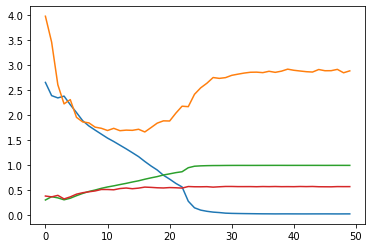

In [61]:
plt.plot(hist)

In [62]:
model = torch.load('newexp/resnewexp_binarysimsloss_resnet50_model.pt')
exp_features = []
exp_labels = []

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sims, sims_labels, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    sims_loss = sims_criterion(sims, sims_labels)
    loss = criterion(outputs, labels) + sims_loss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. test_loss: 2.6100 | Avg. test_acc: 0.5773


In [63]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 2048])

(<Figure size 1080x720 with 1 Axes>,
 array([[-24.141558, -19.933292],
        [-16.784452,   6.748106],
        [ -8.043   , -23.89382 ],
        ...,
        [-17.100426, -10.816095],
        [ 15.410226, -19.308504],
        [ 29.77674 , -31.043108]], dtype=float32))

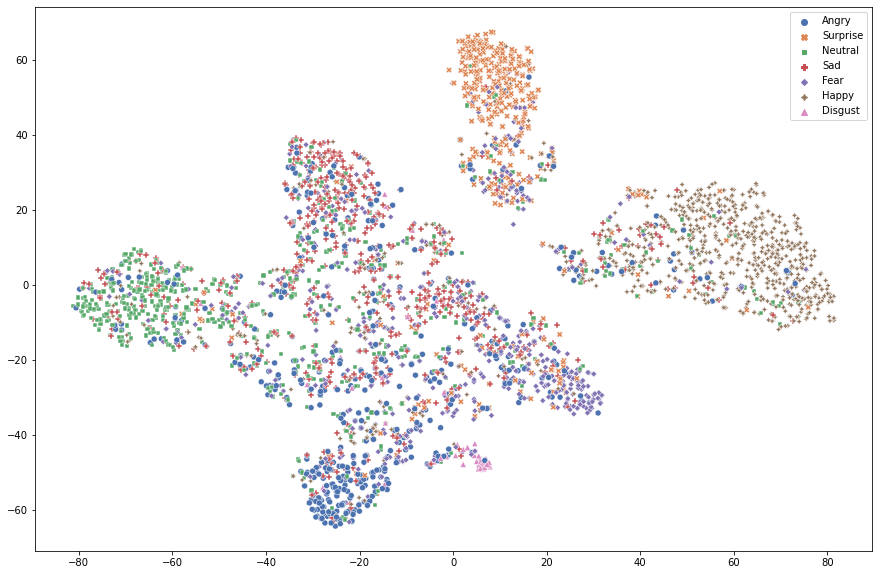

In [64]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

## Add center loss

In [39]:
class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [63]:
labels = torch.randint(0, 7, (12,))
labels = labels.unsqueeze(1).expand(12, 7)
classes = torch.arange(7).long().expand(12, 7)

print(labels)
print(classes)

tensor([[6, 6, 6, 6, 6, 6, 6],
        [2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [5, 5, 5, 5, 5, 5, 5],
        [4, 4, 4, 4, 4, 4, 4],
        [2, 2, 2, 2, 2, 2, 2],
        [4, 4, 4, 4, 4, 4, 4],
        [3, 3, 3, 3, 3, 3, 3],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0]])
tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])


In [106]:
def filter_mask(labels):
    """
    mask zeroing them same
    """
    classes = torch.unique(labels)
    mask = -torch.ones((len(labels), len(labels)))

    for k in classes:
        indices = (labels == k).nonzero().flatten()
        print(k, ' : ', indices)
        lindices = torch.combinations(indices, r=2, with_replacement=True)
        rindices = torch.combinations(indices.flip(0), r=2, with_replacement=True)
        indices = torch.cat([lindices, rindices])
        for ind in indices:
            mask[ind[0], ind[1]] = k 

    return mask

In [107]:
labels = torch.randint(0,7,(12,))
print(labels)
filter_mask(labels)


tensor([3, 4, 3, 5, 3, 3, 5, 6, 6, 5, 3, 1])
tensor(1)  :  tensor([11])
tensor(3)  :  tensor([ 0,  2,  4,  5, 10])
tensor(4)  :  tensor([1])
tensor(5)  :  tensor([3, 6, 9])
tensor(6)  :  tensor([7, 8])


tensor([[ 3., -1.,  3., -1.,  3.,  3., -1., -1., -1., -1.,  3., -1.],
        [-1.,  4., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [ 3., -1.,  3., -1.,  3.,  3., -1., -1., -1., -1.,  3., -1.],
        [-1., -1., -1.,  5., -1., -1.,  5., -1., -1.,  5., -1., -1.],
        [ 3., -1.,  3., -1.,  3.,  3., -1., -1., -1., -1.,  3., -1.],
        [ 3., -1.,  3., -1.,  3.,  3., -1., -1., -1., -1.,  3., -1.],
        [-1., -1., -1.,  5., -1., -1.,  5., -1., -1.,  5., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  6.,  6., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  6.,  6., -1., -1., -1.],
        [-1., -1., -1.,  5., -1., -1.,  5., -1., -1.,  5., -1., -1.],
        [ 3., -1.,  3., -1.,  3.,  3., -1., -1., -1., -1.,  3., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.]])

In [40]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        self.fc2 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x = self.dropout(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        
#         att_mask = torch.where(sims.sigmoid() >= 0.5, 1, 0)
#         att = sims * (att_mask.to(att_mask.device))
#         att = sims.sigmoid()

#         att = self.relu(sims * (torch.eye(len(sims)).to(sims.device)))
        att = sims
        
#         print(att_mask)
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        mask_labels = self.filter_mask(labels)
        mask_labels = 1 - mask_labels # same labels as 1, different labels as 0
        mask_labels = mask_labels.to(labels.device)
        
        return x, sims, mask_labels # sims.sigmoid() and mask_labels are used to cal BCELoss

    def filter_mask(self, labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [41]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
        self.centerloss = CenterLoss(num_classes=n_classes, feat_dim=512, use_gpu=True)
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sims, sims_labels = self.exploss(x, labels)
        centloss = self.centerloss(att, labels)
#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sims, sims_labels, centloss, att
        return x, sims, sims_labels, centloss
        

In [46]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [47]:
lr = 0.0005
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [48]:
model_path = 'newexp/resnewexp_binarysimsloss_centloss_svgg16_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_centloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, centloss, features = model(inputs, labels)
        
        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss + centloss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size(0))
        running_centloss += (centloss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Centloss={centloss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f | Avg.cent_loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), 
                                                                                            running_simloss / len(train_loader.dataset), 
                                                                                            running_centloss / len(train_loader.dataset),
                                                                                            running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valcentloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, centloss, features = model(inputs, labels)

        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss + centloss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size(0))
        running_valcentloss += (centloss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_centloss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), 
                                                                                                                  running_valsimloss / len(val_loader.dataset), 
                                                                                                                  running_valcentloss / len(val_loader.dataset),
                                                                                                                  running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=341.602783203125 Simloss=0.8443853259086609 Centloss=338.8744201660156 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.83it/s]

- Avg.loss: 474.3965 | Avg.sims_loss: 0.7994 | Avg.cent_loss: 471.7702 | Avg.acc: 0.2463


- Avg. test_loss: 644.9546 | Avg. test_sims_loss: 0.774160 | Avg. test_centloss: 642.3562 | Avg. test_acc: 0.2516


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=245.83726501464844 Simloss=1.0387383699417114 Centloss=242.98179626464844 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:18<00:00, 23.95it/s]

- Avg.loss: 286.9469 | Avg.sims_loss: 0.8070 | Avg.cent_loss: 284.3257 | Avg.acc: 0.2531


- Avg. test_loss: 247.9916 | Avg. test_sims_loss: 0.745839 | Avg. test_centloss: 245.4369 | Avg. test_acc: 0.2530


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=165.93731689453125 Simloss=0.8346234560012817 Centloss=163.3457489013672 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.75it/s]

- Avg.loss: 201.8845 | Avg.sims_loss: 0.7935 | Avg.cent_loss: 199.2815 | Avg.acc: 0.2565



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 223.4842 | Avg. test_sims_loss: 0.776306 | Avg. test_centloss: 220.8998 | Avg. test_acc: 0.2527
Epoch:  4


Loss=137.06988525390625 Simloss=0.9486442804336548 Centloss=134.3214569091797 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:18<00:00, 23.84it/s]

- Avg.loss: 142.0154 | Avg.sims_loss: 0.7930 | Avg.cent_loss: 139.4132 | Avg.acc: 0.2554


- Avg. test_loss: 190.6445 | Avg. test_sims_loss: 0.765389 | Avg. test_centloss: 188.0731 | Avg. test_acc: 0.2549


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=80.96865844726562 Simloss=0.847419261932373 Centloss=78.32304382324219 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:18<00:00, 23.84it/s]

- Avg.loss: 98.9197 | Avg.sims_loss: 0.7727 | Avg.cent_loss: 96.3462 | Avg.acc: 0.2562


- Avg. test_loss: 312.4048 | Avg. test_sims_loss: 0.741701 | Avg. test_centloss: 309.8757 | Avg. test_acc: 0.2555


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=51.291831970214844 Simloss=0.9218427538871765 Centloss=48.69828796386719 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.76it/s]

- Avg.loss: 68.2931 | Avg.sims_loss: 0.7605 | Avg.cent_loss: 65.7586 | Avg.acc: 0.2671


- Avg. test_loss: 65.7004 | Avg. test_sims_loss: 0.693189 | Avg. test_centloss: 63.2883 | Avg. test_acc: 0.2926


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=34.975643157958984 Simloss=0.8144233822822571 Centloss=32.5157470703125 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.69it/s]

- Avg.loss: 46.8107 | Avg.sims_loss: 0.7502 | Avg.cent_loss: 44.3378 | Avg.acc: 0.2986


- Avg. test_loss: 51.2912 | Avg. test_sims_loss: 0.695135 | Avg. test_centloss: 48.9122 | Avg. test_acc: 0.3090


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=25.97606086730957 Simloss=0.7023673057556152 Centloss=23.56742286682129 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 31.4668 | Avg.sims_loss: 0.7200 | Avg.cent_loss: 29.0754 | Avg.acc: 0.3188


- Avg. test_loss: 40.1430 | Avg. test_sims_loss: 0.674162 | Avg. test_centloss: 37.8565 | Avg. test_acc: 0.3514


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=18.26738929748535 Simloss=0.7125594615936279 Centloss=15.830041885375977 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:18<00:00, 23.91it/s]

- Avg.loss: 21.1552 | Avg.sims_loss: 0.6763 | Avg.cent_loss: 18.8824 | Avg.acc: 0.3534


- Avg. test_loss: 56.9896 | Avg. test_sims_loss: 0.635841 | Avg. test_centloss: 54.8113 | Avg. test_acc: 0.3887


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=11.792484283447266 Simloss=0.6186818480491638 Centloss=9.568024635314941 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.79it/s]

- Avg.loss: 14.2824 | Avg.sims_loss: 0.6265 | Avg.cent_loss: 12.1204 | Avg.acc: 0.3819


- Avg. test_loss: 44.0157 | Avg. test_sims_loss: 0.613570 | Avg. test_centloss: 41.9070 | Avg. test_acc: 0.3937


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=12.495771408081055 Simloss=0.5057026147842407 Centloss=10.422663688659668 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:18<00:00, 23.75it/s]

- Avg.loss: 9.8502 | Avg.sims_loss: 0.5813 | Avg.cent_loss: 7.7764 | Avg.acc: 0.3948



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2203.0071 | Avg. test_sims_loss: 0.983831 | Avg. test_centloss: 2200.3384 | Avg. test_acc: 0.3892
Epoch:  12


Loss=5.76078462600708 Simloss=0.536202609539032 Centloss=3.5107059478759766 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:18<00:00, 23.81it/s]

- Avg.loss: 8.0665 | Avg.sims_loss: 0.5579 | Avg.cent_loss: 5.7091 | Avg.acc: 0.2511



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 6.6503 | Avg. test_sims_loss: 0.549969 | Avg. test_centloss: 4.3116 | Avg. test_acc: 0.2502
Epoch:  13


Loss=4.480693817138672 Simloss=0.4629261791706085 Centloss=2.2302944660186768 Batch_id=448 Accuracy=0.1891891891891892: 100%|██████████| 449/449 [00:18<00:00, 23.84it/s]

- Avg.loss: 5.2980 | Avg.sims_loss: 0.5239 | Avg.cent_loss: 3.0257 | Avg.acc: 0.2772



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 5.9507 | Avg. test_sims_loss: 0.538159 | Avg. test_centloss: 3.7121 | Avg. test_acc: 0.2823
Epoch:  14


Loss=3.6961557865142822 Simloss=0.4592798352241516 Centloss=1.6304936408996582 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.82it/s]

- Avg.loss: 3.9118 | Avg.sims_loss: 0.5080 | Avg.cent_loss: 1.7809 | Avg.acc: 0.3367



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.8238 | Avg. test_sims_loss: 0.526087 | Avg. test_centloss: 1.7564 | Avg. test_acc: 0.3814
Epoch:  15


Loss=2.8986098766326904 Simloss=0.5206271409988403 Centloss=0.743794858455658 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:18<00:00, 23.75it/s]

- Avg.loss: 3.1031 | Avg.sims_loss: 0.4970 | Avg.cent_loss: 1.0649 | Avg.acc: 0.3784


- Avg. test_loss: 11.8686 | Avg. test_sims_loss: 0.588631 | Avg. test_centloss: 9.7923 | Avg. test_acc: 0.3957


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=2.551386833190918 Simloss=0.5845967531204224 Centloss=0.6148287653923035 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 2.6701 | Avg.sims_loss: 0.4921 | Avg.cent_loss: 0.6694 | Avg.acc: 0.3952


- Avg. test_loss: 5.6525 | Avg. test_sims_loss: 0.562968 | Avg. test_centloss: 3.6262 | Avg. test_acc: 0.4115


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=2.6352248191833496 Simloss=0.5075147747993469 Centloss=0.3822615444660187 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 3.1944 | Avg.sims_loss: 0.4990 | Avg.cent_loss: 0.9973 | Avg.acc: 0.3040



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.8595 | Avg. test_sims_loss: 0.509462 | Avg. test_centloss: 0.6021 | Avg. test_acc: 0.2898
Epoch:  18


Loss=2.276977062225342 Simloss=0.49698296189308167 Centloss=0.25581711530685425 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:18<00:00, 23.77it/s]

- Avg.loss: 2.5539 | Avg.sims_loss: 0.4901 | Avg.cent_loss: 0.3432 | Avg.acc: 0.2975



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.6672 | Avg. test_sims_loss: 0.524249 | Avg. test_centloss: 0.5455 | Avg. test_acc: 0.3592
Epoch:  19


Loss=2.3565616607666016 Simloss=0.5412240028381348 Centloss=0.2306102067232132 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 2.2886 | Avg.sims_loss: 0.4854 | Avg.cent_loss: 0.2351 | Avg.acc: 0.3687



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.7800 | Avg. test_sims_loss: 0.534952 | Avg. test_centloss: 0.7586 | Avg. test_acc: 0.4015
Epoch:  20


Loss=2.702728509902954 Simloss=0.44704338908195496 Centloss=0.3615710437297821 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:18<00:00, 23.84it/s]

- Avg.loss: 2.1460 | Avg.sims_loss: 0.4834 | Avg.cent_loss: 0.1696 | Avg.acc: 0.4009



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.8888 | Avg. test_sims_loss: 0.533710 | Avg. test_centloss: 0.7888 | Avg. test_acc: 0.3901
Epoch:  21


Loss=1.8277568817138672 Simloss=0.4488427937030792 Centloss=0.10424021631479263 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.77it/s]

- Avg.loss: 2.0889 | Avg.sims_loss: 0.4785 | Avg.cent_loss: 0.1520 | Avg.acc: 0.4212


- Avg. test_loss: 3.0658 | Avg. test_sims_loss: 0.527786 | Avg. test_centloss: 1.1147 | Avg. test_acc: 0.4313


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=1.8072408437728882 Simloss=0.4738883972167969 Centloss=0.10468664020299911 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:18<00:00, 23.81it/s]

- Avg.loss: 2.0036 | Avg.sims_loss: 0.4678 | Avg.cent_loss: 0.1145 | Avg.acc: 0.4269


- Avg. test_loss: 2.5195 | Avg. test_sims_loss: 0.505482 | Avg. test_centloss: 0.5931 | Avg. test_acc: 0.4330


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=2.1050634384155273 Simloss=0.5469830632209778 Centloss=0.29703089594841003 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:18<00:00, 23.73it/s]

- Avg.loss: 1.9825 | Avg.sims_loss: 0.4563 | Avg.cent_loss: 0.1249 | Avg.acc: 0.4322


- Avg. test_loss: 2.4723 | Avg. test_sims_loss: 0.495243 | Avg. test_centloss: 0.6024 | Avg. test_acc: 0.4450


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=2.185624122619629 Simloss=0.4517344832420349 Centloss=0.23535239696502686 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:18<00:00, 23.70it/s]

- Avg.loss: 1.9780 | Avg.sims_loss: 0.4491 | Avg.cent_loss: 0.1336 | Avg.acc: 0.4367



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 4.0222 | Avg. test_sims_loss: 0.500543 | Avg. test_centloss: 2.0371 | Avg. test_acc: 0.4026
Epoch:  25


Loss=2.2766404151916504 Simloss=0.5274366140365601 Centloss=0.07980965822935104 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.86it/s]

- Avg.loss: 1.9928 | Avg.sims_loss: 0.4490 | Avg.cent_loss: 0.1356 | Avg.acc: 0.4344



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3538 | Avg. test_sims_loss: 0.463097 | Avg. test_centloss: 0.4733 | Avg. test_acc: 0.4235
Epoch:  26


Loss=1.9830316305160522 Simloss=0.4697501063346863 Centloss=0.10090988129377365 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 23.81it/s]

- Avg.loss: 1.8849 | Avg.sims_loss: 0.4353 | Avg.cent_loss: 0.0940 | Avg.acc: 0.4518



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3415 | Avg. test_sims_loss: 0.462610 | Avg. test_centloss: 0.5034 | Avg. test_acc: 0.4402
Epoch:  27


Loss=1.8563868999481201 Simloss=0.5203238725662231 Centloss=0.04905226454138756 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 23.84it/s]

- Avg.loss: 1.8317 | Avg.sims_loss: 0.4244 | Avg.cent_loss: 0.0710 | Avg.acc: 0.4561


- Avg. test_loss: 3.0602 | Avg. test_sims_loss: 0.450591 | Avg. test_centloss: 1.2862 | Avg. test_acc: 0.4650


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=2.0001518726348877 Simloss=0.5241019129753113 Centloss=0.1446601301431656 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:18<00:00, 23.80it/s]

- Avg.loss: 1.7998 | Avg.sims_loss: 0.4180 | Avg.cent_loss: 0.0689 | Avg.acc: 0.4673



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.8247 | Avg. test_sims_loss: 0.464639 | Avg. test_centloss: 1.0182 | Avg. test_acc: 0.4617
Epoch:  29


Loss=2.0563695430755615 Simloss=0.5114981532096863 Centloss=0.07156681269407272 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:18<00:00, 23.75it/s]

- Avg.loss: 1.8079 | Avg.sims_loss: 0.4192 | Avg.cent_loss: 0.0771 | Avg.acc: 0.4673


- Avg. test_loss: 4.3798 | Avg. test_sims_loss: 0.429568 | Avg. test_centloss: 2.6362 | Avg. test_acc: 0.4748


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=1.691082239151001 Simloss=0.41119325160980225 Centloss=0.034009985625743866 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 23.65it/s]

- Avg.loss: 1.7540 | Avg.sims_loss: 0.4075 | Avg.cent_loss: 0.0547 | Avg.acc: 0.4758



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 5.4774 | Avg. test_sims_loss: 0.471638 | Avg. test_centloss: 3.6863 | Avg. test_acc: 0.4739
Epoch:  31


Loss=1.4592740535736084 Simloss=0.3493565022945404 Centloss=0.09612655639648438 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 23.81it/s]

- Avg.loss: 1.7318 | Avg.sims_loss: 0.4017 | Avg.cent_loss: 0.0583 | Avg.acc: 0.4826



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 6.0995 | Avg. test_sims_loss: 0.459256 | Avg. test_centloss: 4.2330 | Avg. test_acc: 0.4522
Epoch:  32


Loss=1.8960950374603271 Simloss=0.5093172788619995 Centloss=0.04002060741186142 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:18<00:00, 23.78it/s]

- Avg.loss: 1.6868 | Avg.sims_loss: 0.3944 | Avg.cent_loss: 0.0442 | Avg.acc: 0.4975


- Avg. test_loss: 17.3024 | Avg. test_sims_loss: 0.456978 | Avg. test_centloss: 15.4992 | Avg. test_acc: 0.4876
Epoch    32: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=1.6620348691940308 Simloss=0.3622543215751648 Centloss=0.03257906064391136 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:18<00:00, 23.77it/s]

- Avg.loss: 1.5577 | Avg.sims_loss: 0.3718 | Avg.cent_loss: 0.0293 | Avg.acc: 0.5361


- Avg. test_loss: 9.2870 | Avg. test_sims_loss: 0.436005 | Avg. test_centloss: 7.5697 | Avg. test_acc: 0.5029


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=1.4358540773391724 Simloss=0.37082868814468384 Centloss=0.03293692320585251 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 23.77it/s]

- Avg.loss: 1.5221 | Avg.sims_loss: 0.3670 | Avg.cent_loss: 0.0285 | Avg.acc: 0.5478


- Avg. test_loss: 10.7496 | Avg. test_sims_loss: 0.419544 | Avg. test_centloss: 9.0417 | Avg. test_acc: 0.5060


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=1.5975149869918823 Simloss=0.3826371133327484 Centloss=0.021362202242016792 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 23.69it/s]

- Avg.loss: 1.4917 | Avg.sims_loss: 0.3601 | Avg.cent_loss: 0.0263 | Avg.acc: 0.5572


- Avg. test_loss: 18.2993 | Avg. test_sims_loss: 0.461381 | Avg. test_centloss: 16.5294 | Avg. test_acc: 0.5177


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  36


Loss=1.4903390407562256 Simloss=0.3616392910480499 Centloss=0.03774292394518852 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 23.68it/s]

- Avg.loss: 1.4704 | Avg.sims_loss: 0.3555 | Avg.cent_loss: 0.0257 | Avg.acc: 0.5641



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 11.6471 | Avg. test_sims_loss: 0.441977 | Avg. test_centloss: 9.9293 | Avg. test_acc: 0.5113
Epoch:  37


Loss=1.215416669845581 Simloss=0.32646945118904114 Centloss=0.02472563087940216 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:18<00:00, 23.78it/s]

- Avg.loss: 1.4460 | Avg.sims_loss: 0.3516 | Avg.cent_loss: 0.0270 | Avg.acc: 0.5730



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 12.1856 | Avg. test_sims_loss: 0.446008 | Avg. test_centloss: 10.4623 | Avg. test_acc: 0.5157
Epoch:  38


Loss=1.6776031255722046 Simloss=0.46083930134773254 Centloss=0.027221577242016792 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 23.75it/s]

- Avg.loss: 1.4231 | Avg.sims_loss: 0.3462 | Avg.cent_loss: 0.0261 | Avg.acc: 0.5810


- Avg. test_loss: 9.1655 | Avg. test_sims_loss: 0.434228 | Avg. test_centloss: 7.4450 | Avg. test_acc: 0.5241
Epoch    38: reducing learning rate of group 0 to 5.0000e-06.


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=1.254352331161499 Simloss=0.2931787371635437 Centloss=0.02409558743238449 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:18<00:00, 23.73it/s]

- Avg.loss: 1.3846 | Avg.sims_loss: 0.3406 | Avg.cent_loss: 0.0239 | Avg.acc: 0.5972



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 13.3368 | Avg. test_sims_loss: 0.459458 | Avg. test_centloss: 11.5704 | Avg. test_acc: 0.5121
Epoch:  40


Loss=1.2535743713378906 Simloss=0.33718711137771606 Centloss=0.03742661327123642 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 23.77it/s]

- Avg.loss: 1.3799 | Avg.sims_loss: 0.3398 | Avg.cent_loss: 0.0233 | Avg.acc: 0.5960



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 9.8359 | Avg. test_sims_loss: 0.427683 | Avg. test_centloss: 8.1137 | Avg. test_acc: 0.5096
Epoch:  41


Loss=1.5745166540145874 Simloss=0.3769126534461975 Centloss=0.04505642130970955 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]

- Avg.loss: 1.3754 | Avg.sims_loss: 0.3396 | Avg.cent_loss: 0.0235 | Avg.acc: 0.5967



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 17.5946 | Avg. test_sims_loss: 0.445925 | Avg. test_centloss: 15.8487 | Avg. test_acc: 0.5163
Epoch:  42


Loss=1.1737961769104004 Simloss=0.30081355571746826 Centloss=0.01704627275466919 Batch_id=388 Accuracy=0.703125:  87%|████████▋ | 389/449 [00:16<00:02, 23.48it/s] 


KeyboardInterrupt: 

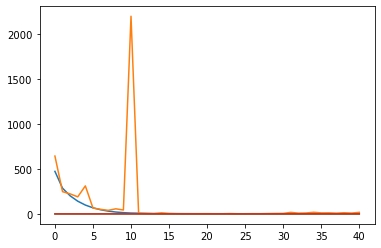

In [49]:
plt.plot(hist)

In [53]:
model = torch.load('newexp/resnewexp_binarysimsloss_centloss_svgg16_model.pt')
exp_features = []
exp_labels = []


# EVALUATE
model.eval()
running_valloss = 0.0
running_valsimloss = 0.0
running_valcentloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sims, sims_labels, centloss, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    sims_loss = sims_criterion(sims, sims_labels)
    loss = criterion(outputs, labels) + sims_loss + centloss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valsimloss += (sims_loss.item() * inputs.size(0))
    running_valcentloss += (centloss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_centloss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), 
                                                                                                              running_valsimloss / len(test_loader.dataset), 
                                                                                                              running_valcentloss / len(test_loader.dataset),
                                                                                                              running_valacc / len(test_loader.dataset)))

- Avg. test_loss: 2609.5518 | Avg. test_sims_loss: 0.446586 | Avg. test_centloss: 2607.5142 | Avg. test_acc: 0.5327


In [54]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[-32.859962,  27.76872 ],
        [-31.043253,  28.736261],
        [-48.261745,  12.924452],
        ...,
        [ 32.965446,  30.240238],
        [-55.53455 ,  -8.359179],
        [ 11.324579,  29.89393 ]], dtype=float32))

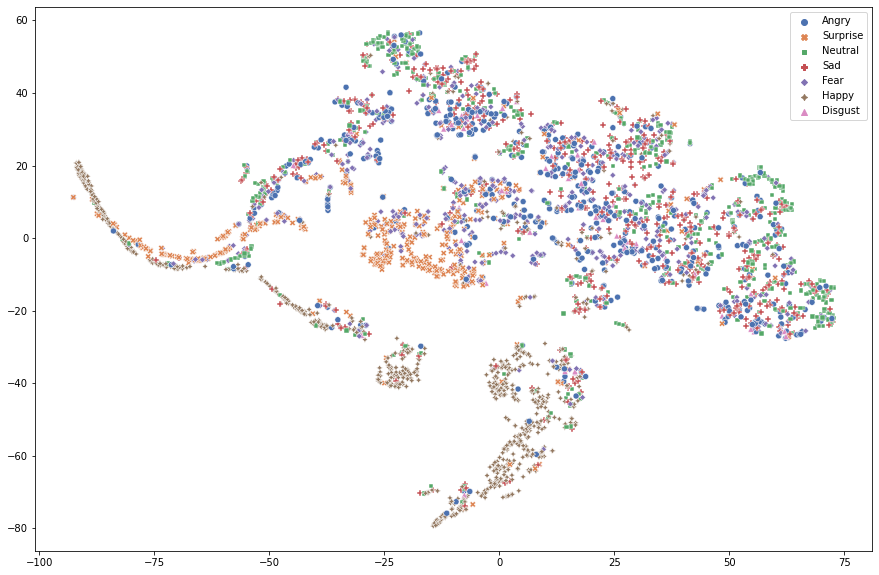

In [55]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

## Exploss with specific classes

In [ ]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        self.fc2 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x = self.dropout(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        
#         att_mask = torch.where(sims.sigmoid() >= 0.5, 1, 0)
#         att = sims * (att_mask.to(att_mask.device))
#         att = sims.sigmoid()

#         att = self.relu(sims * (torch.eye(len(sims)).to(sims.device)))
        att = sims
        
#         print(att_mask)
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        mask_labels = self.filter_mask(labels)
        mask_labels = 1 - mask_labels # same labels as 1, different labels as 0
        mask_labels = mask_labels.to(labels.device)
        
        return x, sims, mask_labels # sims.sigmoid() and mask_labels are used to cal BCELoss

    def filter_mask(labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))

        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]
        indices = [torch.unique(k, dim=0) for k in indices]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.

        spec_masks = []
        for k in indices:
            _temp = torch.zeros((len(labels), len(labels)))
            _temp[k[:,0], k[:,1]] = 1
            spec_masks.append(_temp)

        return mask, spec_masks

In [6]:
labels = torch.randint(0,7,(12,))
att = torch.rand(12,12)
labels, att

(tensor([3, 6, 2, 1, 2, 6, 2, 6, 5, 3, 6, 0]),
 tensor([[0.2238, 0.4089, 0.3193, 0.6768, 0.0140, 0.0216, 0.3362, 0.1721, 0.9846,
          0.8316, 0.2960, 0.7925],
         [0.7032, 0.6575, 0.5682, 0.3373, 0.7371, 0.2684, 0.1965, 0.7400, 0.0024,
          0.4135, 0.3168, 0.2778],
         [0.6817, 0.1443, 0.9082, 0.8288, 0.7173, 0.5178, 0.0886, 0.0077, 0.9530,
          0.8720, 0.0205, 0.7240],
         [0.0096, 0.4544, 0.5442, 0.5249, 0.1838, 0.4730, 0.7603, 0.7099, 0.3782,
          0.2043, 0.3803, 0.1810],
         [0.1081, 0.5190, 0.9687, 0.4492, 0.8105, 0.9856, 0.1826, 0.9011, 0.9328,
          0.0663, 0.0247, 0.6990],
         [0.7953, 0.2529, 0.0170, 0.2680, 0.9145, 0.4954, 0.6570, 0.7309, 0.3172,
          0.1736, 0.5087, 0.5309],
         [0.5321, 0.3275, 0.1821, 0.1938, 0.9284, 0.5834, 0.8828, 0.2186, 0.4545,
          0.7739, 0.3517, 0.0211],
         [0.9409, 0.1801, 0.9643, 0.0761, 0.4247, 0.3915, 0.8768, 0.7426, 0.9678,
          0.6543, 0.9094, 0.9405],
         [0.5617,

In [61]:
def filter_mask(labels):
    """
    mask zeroing them same
    """
    classes = torch.unique(labels)
    mask = torch.ones((len(labels), len(labels)))

    indices = [(labels == k).nonzero().flatten() for k in classes]
    lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
    rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
    indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]
    indices = [torch.unique(k, dim=0) for k in indices]

    for k in indices:
        mask[k[:,0], k[:,1]] = 0.
        
    spec_masks = []
    for k in indices:
        _temp = torch.zeros((len(labels), len(labels)))
        _temp[k[:,0], k[:,1]] = 1
        spec_masks.append(_temp)
        
    return mask, spec_masks

In [62]:
mask, spec_masks = filter_mask(labels)
indices

[tensor([[11, 11]]),
 tensor([[3, 3]]),
 tensor([[2, 2],
         [2, 4],
         [2, 6],
         [4, 2],
         [4, 4],
         [4, 6],
         [6, 2],
         [6, 4],
         [6, 6]]),
 tensor([[0, 0],
         [0, 9],
         [9, 0],
         [9, 9]]),
 tensor([[8, 8]]),
 tensor([[ 1,  1],
         [ 1,  5],
         [ 1,  7],
         [ 1, 10],
         [ 5,  1],
         [ 5,  5],
         [ 5,  7],
         [ 5, 10],
         [ 7,  1],
         [ 7,  5],
         [ 7,  7],
         [ 7, 10],
         [10,  1],
         [10,  5],
         [10,  7],
         [10, 10]])]

In [63]:
spec_masks

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [55]:
a = [torch.zeros(12,12)[k[:,0], k[:,1]] = 1 for k in indices]
a

SyntaxError: invalid syntax (<ipython-input-55-6efba5df98c9>, line 1)

In [42]:
b = torch.zeros(12,12)
b[indices[0][:,0], indices[0][:,1]] = 1
b

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

## Exploss | Change to cosine sims + BCEWithLogitLoss

In [66]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        self.fc2 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x = self.dropout(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # normalize
        x1 = x1 / x1.norm(dim=1)[:,None]
        x2 = x2 / x2.norm(dim=1)[:,None]
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        
        att_mask = torch.where(sims >= 0, 1, 0)
        att = sims * (att_mask.to(att_mask.device))
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        mask_labels = self.filter_mask(labels)
        mask_labels = 1 - mask_labels # same labels as 1, different labels as 0
        mask_labels = mask_labels.to(labels.device)
        
        return x, sims, mask_labels # sims.sigmoid() and mask_labels are used to cal BCELoss

    def filter_mask(self, labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))

        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]
        indices = [torch.unique(k, dim=0) for k in indices]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.

        spec_masks = []
        for k in indices:
            _temp = torch.zeros((len(labels), len(labels)))
            _temp[k[:,0], k[:,1]] = 1
            spec_masks.append(_temp)

        return mask

In [67]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sims, sims_labels = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sims, sims_labels, att
        return x, sims, sims_labels
        

In [68]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [69]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
sims_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [71]:
model_path = 'newexp_new/svgg_cosinesims_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features = model(inputs, labels)
        
        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features = model(inputs, labels)

        sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=2.29622745513916 Simloss=0.5259290337562561 Batch_id=448 Accuracy=0.21621621621621623: 100%|██████████| 449/449 [00:18<00:00, 23.94it/s]

- Avg.loss: 2.4165 | Avg.sims_loss: 0.5928 |Avg.acc: 0.2420



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.2441 | Avg. test_sims_loss: 0.555324 | Avg. test_acc: 0.2494
* Update optimal model
Epoch:  2


Loss=2.468736171722412 Simloss=0.5548555254936218 Batch_id=448 Accuracy=0.13513513513513514: 100%|██████████| 449/449 [00:18<00:00, 23.92it/s]

- Avg.loss: 2.3437 | Avg.sims_loss: 0.5395 |Avg.acc: 0.2488



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3721 | Avg. test_sims_loss: 0.503477 | Avg. test_acc: 0.1468
Epoch:  3


Loss=2.2860445976257324 Simloss=0.5002940893173218 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:18<00:00, 23.89it/s]

- Avg.loss: 2.3181 | Avg.sims_loss: 0.5229 |Avg.acc: 0.2528


- Avg. test_loss: 2.3730 | Avg. test_sims_loss: 0.502380 | Avg. test_acc: 0.2508


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=2.3486666679382324 Simloss=0.48758935928344727 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:18<00:00, 23.79it/s]

- Avg.loss: 2.2383 | Avg.sims_loss: 0.5072 |Avg.acc: 0.2914



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3815 | Avg. test_sims_loss: 0.501853 | Avg. test_acc: 0.2497
Epoch:  5


Loss=1.9940129518508911 Simloss=0.5352592468261719 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 23.78it/s]


- Avg.loss: 2.0923 | Avg.sims_loss: 0.5036 |Avg.acc: 0.3623
- Avg. test_loss: 2.0827 | Avg. test_sims_loss: 0.509282 | Avg. test_acc: 0.3734


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.718445062637329 Simloss=0.510487973690033 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:18<00:00, 23.73it/s]

- Avg.loss: 1.9478 | Avg.sims_loss: 0.4981 |Avg.acc: 0.4224


- Avg. test_loss: 1.8725 | Avg. test_sims_loss: 0.499288 | Avg. test_acc: 0.4553


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=2.25347900390625 Simloss=0.51314777135849 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:18<00:00, 23.69it/s]


- Avg.loss: 1.8799 | Avg.sims_loss: 0.4960 |Avg.acc: 0.4474


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.0735 | Avg. test_sims_loss: 0.495748 | Avg. test_acc: 0.3798
Epoch:  8


Loss=2.0434677600860596 Simloss=0.48576539754867554 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:18<00:00, 23.74it/s]

- Avg.loss: 1.8514 | Avg.sims_loss: 0.4959 |Avg.acc: 0.4569


- Avg. test_loss: 1.8044 | Avg. test_sims_loss: 0.494734 | Avg. test_acc: 0.4751


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.8471038341522217 Simloss=0.49309828877449036 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:18<00:00, 23.66it/s]

- Avg.loss: 1.8213 | Avg.sims_loss: 0.4946 |Avg.acc: 0.4715



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.8955 | Avg. test_sims_loss: 0.516680 | Avg. test_acc: 0.4427
Epoch:  10


Loss=2.0046510696411133 Simloss=0.49151304364204407 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]


- Avg.loss: 1.8019 | Avg.sims_loss: 0.4960 |Avg.acc: 0.4879
- Avg. test_loss: 1.7652 | Avg. test_sims_loss: 0.494775 | Avg. test_acc: 0.5074


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.9920258522033691 Simloss=0.5014825463294983 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.69it/s]

- Avg.loss: 1.7595 | Avg.sims_loss: 0.4934 |Avg.acc: 0.5059


- Avg. test_loss: 1.7110 | Avg. test_sims_loss: 0.493535 | Avg. test_acc: 0.5327


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.7715505361557007 Simloss=0.4877130091190338 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:18<00:00, 23.68it/s]

- Avg.loss: 1.7046 | Avg.sims_loss: 0.4932 |Avg.acc: 0.5376



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.7242 | Avg. test_sims_loss: 0.492569 | Avg. test_acc: 0.5280
Epoch:  13


Loss=1.6599268913269043 Simloss=0.5387042164802551 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:18<00:00, 23.75it/s]

- Avg.loss: 1.6503 | Avg.sims_loss: 0.4918 |Avg.acc: 0.5620


- Avg. test_loss: 1.6401 | Avg. test_sims_loss: 0.491760 | Avg. test_acc: 0.5623


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.9713075160980225 Simloss=0.5156139731407166 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 23.67it/s]

- Avg.loss: 1.6165 | Avg.sims_loss: 0.4915 |Avg.acc: 0.5748



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.8585 | Avg. test_sims_loss: 0.497834 | Avg. test_acc: 0.5052
Epoch:  15


Loss=1.7707808017730713 Simloss=0.4934799075126648 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 23.65it/s]

- Avg.loss: 1.5918 | Avg.sims_loss: 0.4912 |Avg.acc: 0.5912


- Avg. test_loss: 1.5896 | Avg. test_sims_loss: 0.491144 | Avg. test_acc: 0.5782


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.5668236017227173 Simloss=0.5109992027282715 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.62it/s]

- Avg.loss: 1.5671 | Avg.sims_loss: 0.4915 |Avg.acc: 0.6015


- Avg. test_loss: 1.5945 | Avg. test_sims_loss: 0.490990 | Avg. test_acc: 0.5979


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=1.6394896507263184 Simloss=0.47438326478004456 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 23.70it/s]

- Avg.loss: 1.5416 | Avg.sims_loss: 0.4903 |Avg.acc: 0.6106


- Avg. test_loss: 1.5781 | Avg. test_sims_loss: 0.491407 | Avg. test_acc: 0.5991


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.5452569723129272 Simloss=0.5058528184890747 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 23.64it/s]

- Avg.loss: 1.5144 | Avg.sims_loss: 0.4909 |Avg.acc: 0.6225


- Avg. test_loss: 1.5674 | Avg. test_sims_loss: 0.490968 | Avg. test_acc: 0.6116


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.5809099674224854 Simloss=0.5089430212974548 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 23.63it/s]

- Avg.loss: 1.4942 | Avg.sims_loss: 0.4901 |Avg.acc: 0.6288



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6081 | Avg. test_sims_loss: 0.491460 | Avg. test_acc: 0.5857
Epoch:  20


Loss=1.5381208658218384 Simloss=0.49903130531311035 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 23.68it/s]

- Avg.loss: 1.4656 | Avg.sims_loss: 0.4893 |Avg.acc: 0.6440


- Avg. test_loss: 1.5347 | Avg. test_sims_loss: 0.490885 | Avg. test_acc: 0.6180


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=1.5985078811645508 Simloss=0.5025784969329834 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:18<00:00, 23.67it/s]

- Avg.loss: 1.4464 | Avg.sims_loss: 0.4898 |Avg.acc: 0.6539



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5348 | Avg. test_sims_loss: 0.491904 | Avg. test_acc: 0.6110
Epoch:  22


Loss=1.7628064155578613 Simloss=0.5049418807029724 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 23.71it/s]

- Avg.loss: 1.4196 | Avg.sims_loss: 0.4886 |Avg.acc: 0.6641



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5709 | Avg. test_sims_loss: 0.491116 | Avg. test_acc: 0.6055
Epoch:  23


Loss=1.2074785232543945 Simloss=0.4964020252227783 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:18<00:00, 23.67it/s]

- Avg.loss: 1.4033 | Avg.sims_loss: 0.4886 |Avg.acc: 0.6709



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.7013 | Avg. test_sims_loss: 0.493510 | Avg. test_acc: 0.5862
Epoch:  24


Loss=1.4375683069229126 Simloss=0.483358234167099 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 23.69it/s]

- Avg.loss: 1.3760 | Avg.sims_loss: 0.4891 |Avg.acc: 0.6807



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5615 | Avg. test_sims_loss: 0.491284 | Avg. test_acc: 0.6124
Epoch:  25


Loss=1.2685314416885376 Simloss=0.49396374821662903 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:18<00:00, 23.65it/s]


- Avg.loss: 1.3501 | Avg.sims_loss: 0.4881 |Avg.acc: 0.6907
- Avg. test_loss: 1.5404 | Avg. test_sims_loss: 0.490425 | Avg. test_acc: 0.6241


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=1.6775774955749512 Simloss=0.5014615654945374 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:18<00:00, 23.70it/s]


- Avg.loss: 1.3301 | Avg.sims_loss: 0.4877 |Avg.acc: 0.6961
- Avg. test_loss: 1.5486 | Avg. test_sims_loss: 0.490190 | Avg. test_acc: 0.6356
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=1.0735831260681152 Simloss=0.47157421708106995 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:18<00:00, 23.66it/s]

- Avg.loss: 1.2099 | Avg.sims_loss: 0.4856 |Avg.acc: 0.7415


- Avg. test_loss: 1.5137 | Avg. test_sims_loss: 0.489956 | Avg. test_acc: 0.6531


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=1.1264911890029907 Simloss=0.48724308609962463 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 23.65it/s]

- Avg.loss: 1.1674 | Avg.sims_loss: 0.4845 |Avg.acc: 0.7595


- Avg. test_loss: 1.5308 | Avg. test_sims_loss: 0.490116 | Avg. test_acc: 0.6565


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=1.0638127326965332 Simloss=0.4653170704841614 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:18<00:00, 23.65it/s]


- Avg.loss: 1.1412 | Avg.sims_loss: 0.4845 |Avg.acc: 0.7702


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5476 | Avg. test_sims_loss: 0.490519 | Avg. test_acc: 0.6542
Epoch:  30


Loss=1.3551740646362305 Simloss=0.5565919876098633 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:18<00:00, 23.70it/s]

- Avg.loss: 1.1276 | Avg.sims_loss: 0.4848 |Avg.acc: 0.7763



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5514 | Avg. test_sims_loss: 0.490534 | Avg. test_acc: 0.6545
Epoch:  31


Loss=0.9367347359657288 Simloss=0.4814017415046692 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:18<00:00, 23.70it/s]


- Avg.loss: 1.1084 | Avg.sims_loss: 0.4848 |Avg.acc: 0.7822
- Avg. test_loss: 1.5743 | Avg. test_sims_loss: 0.490630 | Avg. test_acc: 0.6573


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  32


Loss=1.1731781959533691 Simloss=0.48665672540664673 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.62it/s]


- Avg.loss: 1.0918 | Avg.sims_loss: 0.4839 |Avg.acc: 0.7896


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.5876 | Avg. test_sims_loss: 0.490913 | Avg. test_acc: 0.6556
Epoch:  33


Loss=0.996295154094696 Simloss=0.5064152479171753 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:18<00:00, 23.72it/s]


- Avg.loss: 1.0762 | Avg.sims_loss: 0.4844 |Avg.acc: 0.7943
- Avg. test_loss: 1.5974 | Avg. test_sims_loss: 0.491071 | Avg. test_acc: 0.6606
Epoch    33: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=1.265089511871338 Simloss=0.4999774694442749 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.61it/s]


- Avg.loss: 1.0545 | Avg.sims_loss: 0.4834 |Avg.acc: 0.8052


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6069 | Avg. test_sims_loss: 0.490930 | Avg. test_acc: 0.6592
Epoch:  35


Loss=1.0471584796905518 Simloss=0.4922621548175812 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:18<00:00, 23.65it/s]


- Avg.loss: 1.0421 | Avg.sims_loss: 0.4828 |Avg.acc: 0.8076


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6185 | Avg. test_sims_loss: 0.490746 | Avg. test_acc: 0.6556
Epoch:  36


Loss=1.135631799697876 Simloss=0.5014151930809021 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.61it/s]

- Avg.loss: 1.0510 | Avg.sims_loss: 0.4839 |Avg.acc: 0.8052



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6089 | Avg. test_sims_loss: 0.490831 | Avg. test_acc: 0.6578
Epoch:  37


Loss=0.9390970468521118 Simloss=0.46627628803253174 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.59it/s]

- Avg.loss: 1.0409 | Avg.sims_loss: 0.4836 |Avg.acc: 0.8078



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6220 | Avg. test_sims_loss: 0.491156 | Avg. test_acc: 0.6556
Epoch:  38


Loss=1.0425384044647217 Simloss=0.5094712972640991 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:18<00:00, 23.66it/s]

- Avg.loss: 1.0372 | Avg.sims_loss: 0.4831 |Avg.acc: 0.8107



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 1.6174 | Avg. test_sims_loss: 0.491059 | Avg. test_acc: 0.6542
Epoch:  39


Loss=0.9747198820114136 Simloss=0.48127156496047974 Batch_id=160 Accuracy=0.859375:  36%|███▌      | 161/449 [00:07<00:12, 22.92it/s]


KeyboardInterrupt: 

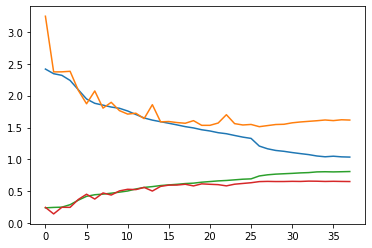

In [73]:
plt.plot(hist)

In [89]:
model = torch.load('newexp_new/svgg_cosinesims_model.pt')
exp_features = []
exp_labels = []
_sims = []
_sims_labels = []

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sims, sims_labels, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())
        _sims.append(sims.detach().cpu())
        _sims_labels.append(sims_labels.detach().cpu())

    sims_loss = sims_criterion(sims, sims_labels)
    loss = criterion(outputs, labels) + sims_loss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. test_loss: 1.4901 | Avg. test_acc: 0.6874


In [75]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[-41.139    , -10.082969 ],
        [ -4.0298405,   2.0048974],
        [-38.62461  ,  11.074682 ],
        ...,
        [-44.78194  ,  11.973054 ],
        [ 27.38286  , -18.673595 ],
        [-40.418114 ,   4.021873 ]], dtype=float32))

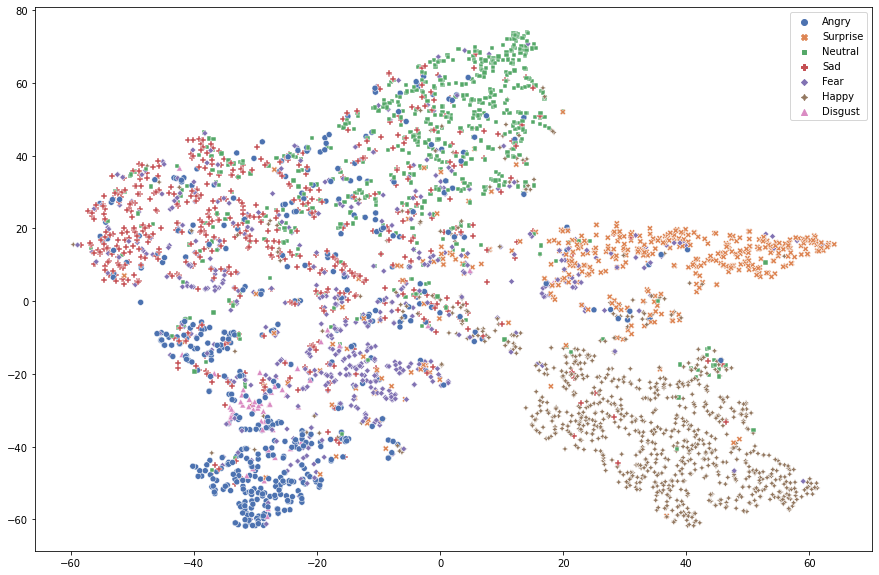

In [76]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

In [94]:
for index in range(len(_sims)):
    print((_sims[index] >= 0).float().sum(), (_sims[index] < 0).float().sum())
    print((_sims_labels[index] == 1).float().sum(), (_sims_labels[index] == 0).float().sum())
    print('---')

tensor(58.) tensor(4038.)
tensor(722.) tensor(3374.)
---
tensor(234.) tensor(3862.)
tensor(800.) tensor(3296.)
---
tensor(138.) tensor(3958.)
tensor(752.) tensor(3344.)
---
tensor(25.) tensor(4071.)
tensor(654.) tensor(3442.)
---
tensor(156.) tensor(3940.)
tensor(846.) tensor(3250.)
---
tensor(168.) tensor(3928.)
tensor(748.) tensor(3348.)
---
tensor(162.) tensor(3934.)
tensor(778.) tensor(3318.)
---
tensor(143.) tensor(3953.)
tensor(746.) tensor(3350.)
---
tensor(146.) tensor(3950.)
tensor(790.) tensor(3306.)
---
tensor(201.) tensor(3895.)
tensor(712.) tensor(3384.)
---
tensor(185.) tensor(3911.)
tensor(738.) tensor(3358.)
---
tensor(70.) tensor(4026.)
tensor(738.) tensor(3358.)
---
tensor(275.) tensor(3821.)
tensor(866.) tensor(3230.)
---
tensor(230.) tensor(3866.)
tensor(736.) tensor(3360.)
---
tensor(180.) tensor(3916.)
tensor(764.) tensor(3332.)
---
tensor(251.) tensor(3845.)
tensor(780.) tensor(3316.)
---
tensor(162.) tensor(3934.)
tensor(686.) tensor(3410.)
---
tensor(100.) tens

In [109]:
-(1-(_sims[0] * (1-_sims_labels[0])).sigmoid()).log().mean()

tensor(0.4166)

## Exploss | Change to cosine sims + New loss

In [115]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        self.fc2 = nn.Sequential(nn.Linear(depth, depth),
                                 nn.BatchNorm1d(depth))
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x = self.dropout(x)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # normalize
        x1 = x1 / x1.norm(dim=1)[:,None]
        x2 = x2 / x2.norm(dim=1)[:,None]
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        
        att_mask = torch.where(sims >= 0, 1, 0)
        att = sims * (att_mask.to(att_mask.device))
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        neg_mask_labels = self.filter_mask(labels)
        pos_mask_labels = 1 - neg_mask_labels # same labels as 1, different labels as 0
        
        pos_samples = sims * pos_mask_labels.to(labels.device)
        neg_samples = sims * neg_mask_labels.to(labels.device)
        
        pos_samples = pos_samples.to(labels.device)
        neg_samples = neg_samples.to(labels.device)
        
        pos_loss = -torch.log(pos_samples.sigmoid()).mean()
        neg_loss = -torch.log(1 - (neg_samples.sigmoid())).mean()
        
        mask_labels = pos_mask_labels.to(labels.device)
        
        return x, sims, mask_labels, pos_loss, neg_loss # sims.sigmoid() and mask_labels are used to cal BCELoss

    def filter_mask(self, labels):
        """
        mask zeroing them same
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))

        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]
        indices = [torch.unique(k, dim=0) for k in indices]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.

        spec_masks = []
        for k in indices:
            _temp = torch.zeros((len(labels), len(labels)))
            _temp[k[:,0], k[:,1]] = 1
            spec_masks.append(_temp)

        return mask

In [116]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sims, sims_labels, pos_loss, neg_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sims, sims_labels, att, pos_loss+neg_loss
        return x, sims, sims_labels, pos_loss+neg_loss
        

In [117]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [118]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# sims_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [119]:
model_path = 'newexp_new/svgg_cosinesims_logloss_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_simloss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)
        
#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_simloss += (sims_loss.item() * inputs.size((0)))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Simloss={sims_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.sims_loss: %.4f |Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_simloss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valsimloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)

#         sims_loss = sims_criterion(sims, sims_labels)
        loss = criterion(outputs, labels) + sims_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valsimloss += (sims_loss.item() * inputs.size((0)))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_sims_loss: %4f | Avg. test_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valsimloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)

    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=3.060917377471924 Simloss=1.2776572704315186 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:18<00:00, 23.84it/s]

- Avg.loss: 3.1265 | Avg.sims_loss: 1.3006 |Avg.acc: 0.2417



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.1010 | Avg. test_sims_loss: 1.207155 | Avg. test_acc: 0.2494
* Update optimal model
Epoch:  2


Loss=3.000075101852417 Simloss=1.2317123413085938 Batch_id=448 Accuracy=0.1891891891891892: 100%|██████████| 449/449 [00:18<00:00, 23.76it/s]

- Avg.loss: 3.0462 | Avg.sims_loss: 1.2371 |Avg.acc: 0.2504



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 3.4671 | Avg. test_sims_loss: 1.244482 | Avg. test_acc: 0.2494
Epoch:  3


Loss=3.0290799140930176 Simloss=1.2460260391235352 Batch_id=448 Accuracy=0.1891891891891892: 100%|██████████| 449/449 [00:18<00:00, 23.73it/s]

- Avg.loss: 3.0001 | Avg.sims_loss: 1.2157 |Avg.acc: 0.2599



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 4.2745 | Avg. test_sims_loss: 1.294669 | Avg. test_acc: 0.1530
Epoch:  4


Loss=2.785024881362915 Simloss=1.2340012788772583 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:18<00:00, 23.69it/s]

- Avg.loss: 2.9025 | Avg.sims_loss: 1.2022 |Avg.acc: 0.3046


- Avg. test_loss: 2.8465 | Avg. test_sims_loss: 1.196152 | Avg. test_acc: 0.3174


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=2.7145795822143555 Simloss=1.2129396200180054 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:18<00:00, 23.64it/s]

- Avg.loss: 2.7736 | Avg.sims_loss: 1.1932 |Avg.acc: 0.3591


- Avg. test_loss: 2.6338 | Avg. test_sims_loss: 1.190488 | Avg. test_acc: 0.4235


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=2.7197179794311523 Simloss=1.1833252906799316 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:19<00:00, 23.63it/s]

- Avg.loss: 2.6370 | Avg.sims_loss: 1.1899 |Avg.acc: 0.4204



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.6971 | Avg. test_sims_loss: 1.189407 | Avg. test_acc: 0.4163
Epoch:  7


Loss=2.583282947540283 Simloss=1.1828583478927612 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:19<00:00, 23.62it/s]


- Avg.loss: 2.5761 | Avg.sims_loss: 1.1893 |Avg.acc: 0.4416
- Avg. test_loss: 2.5624 | Avg. test_sims_loss: 1.188685 | Avg. test_acc: 0.4500


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=2.508180856704712 Simloss=1.2014589309692383 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:19<00:00, 23.62it/s]

- Avg.loss: 2.5369 | Avg.sims_loss: 1.1879 |Avg.acc: 0.4512


- Avg. test_loss: 2.5267 | Avg. test_sims_loss: 1.187169 | Avg. test_acc: 0.4603


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=2.629488945007324 Simloss=1.189669132232666 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:19<00:00, 23.52it/s]

- Avg.loss: 2.5033 | Avg.sims_loss: 1.1878 |Avg.acc: 0.4702


- Avg. test_loss: 2.5004 | Avg. test_sims_loss: 1.190290 | Avg. test_acc: 0.4781


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=2.514017105102539 Simloss=1.204888939857483 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:19<00:00, 23.57it/s]

- Avg.loss: 2.4572 | Avg.sims_loss: 1.1865 |Avg.acc: 0.5084


- Avg. test_loss: 2.4521 | Avg. test_sims_loss: 1.186388 | Avg. test_acc: 0.5180


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=2.410828113555908 Simloss=1.1698555946350098 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.48it/s]

- Avg.loss: 2.4050 | Avg.sims_loss: 1.1862 |Avg.acc: 0.5381


- Avg. test_loss: 2.3755 | Avg. test_sims_loss: 1.185476 | Avg. test_acc: 0.5497


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=2.051755428314209 Simloss=1.1803548336029053 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 23.51it/s]

- Avg.loss: 2.3586 | Avg.sims_loss: 1.1857 |Avg.acc: 0.5553


- Avg. test_loss: 2.3978 | Avg. test_sims_loss: 1.186471 | Avg. test_acc: 0.5503


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=2.373450517654419 Simloss=1.1914472579956055 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.53it/s]

- Avg.loss: 2.3232 | Avg.sims_loss: 1.1859 |Avg.acc: 0.5747


- Avg. test_loss: 2.3244 | Avg. test_sims_loss: 1.185727 | Avg. test_acc: 0.5684


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=2.6383233070373535 Simloss=1.2230274677276611 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:19<00:00, 23.52it/s]

- Avg.loss: 2.2862 | Avg.sims_loss: 1.1849 |Avg.acc: 0.5896



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3234 | Avg. test_sims_loss: 1.185245 | Avg. test_acc: 0.5681
Epoch:  15


Loss=2.450683116912842 Simloss=1.1931447982788086 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 23.60it/s]

- Avg.loss: 2.2600 | Avg.sims_loss: 1.1837 |Avg.acc: 0.6071



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.4072 | Avg. test_sims_loss: 1.187234 | Avg. test_acc: 0.5584
Epoch:  16


Loss=2.455273151397705 Simloss=1.201781988143921 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:18<00:00, 23.64it/s]

- Avg.loss: 2.2271 | Avg.sims_loss: 1.1843 |Avg.acc: 0.6156


- Avg. test_loss: 2.2680 | Avg. test_sims_loss: 1.186146 | Avg. test_acc: 0.5965


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=2.224780559539795 Simloss=1.1882054805755615 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 23.48it/s]

- Avg.loss: 2.2008 | Avg.sims_loss: 1.1830 |Avg.acc: 0.6305



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2773 | Avg. test_sims_loss: 1.185225 | Avg. test_acc: 0.5882
Epoch:  18


Loss=2.350879430770874 Simloss=1.1723778247833252 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 23.60it/s]

- Avg.loss: 2.1721 | Avg.sims_loss: 1.1827 |Avg.acc: 0.6397


- Avg. test_loss: 2.2875 | Avg. test_sims_loss: 1.186507 | Avg. test_acc: 0.5988


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=2.1483001708984375 Simloss=1.2002922296524048 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 23.51it/s]

- Avg.loss: 2.1519 | Avg.sims_loss: 1.1828 |Avg.acc: 0.6487


- Avg. test_loss: 2.2136 | Avg. test_sims_loss: 1.184188 | Avg. test_acc: 0.6244


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=2.53529953956604 Simloss=1.1983435153961182 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.56it/s]

- Avg.loss: 2.1338 | Avg.sims_loss: 1.1825 |Avg.acc: 0.6573



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2781 | Avg. test_sims_loss: 1.185918 | Avg. test_acc: 0.6060
Epoch:  21


Loss=2.014798402786255 Simloss=1.1824610233306885 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.60it/s]

- Avg.loss: 2.1103 | Avg.sims_loss: 1.1821 |Avg.acc: 0.6664



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3474 | Avg. test_sims_loss: 1.184904 | Avg. test_acc: 0.5932
Epoch:  22


Loss=2.0603928565979004 Simloss=1.1810553073883057 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.59it/s]

- Avg.loss: 2.0810 | Avg.sims_loss: 1.1821 |Avg.acc: 0.6747



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3512 | Avg. test_sims_loss: 1.184174 | Avg. test_acc: 0.6030
Epoch:  23


Loss=2.265570640563965 Simloss=1.1863205432891846 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 23.58it/s]

- Avg.loss: 2.0567 | Avg.sims_loss: 1.1813 |Avg.acc: 0.6875



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2753 | Avg. test_sims_loss: 1.184591 | Avg. test_acc: 0.6166
Epoch:  24


Loss=2.1077756881713867 Simloss=1.178904414176941 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.55it/s]

- Avg.loss: 2.0367 | Avg.sims_loss: 1.1811 |Avg.acc: 0.6940



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2946 | Avg. test_sims_loss: 1.184585 | Avg. test_acc: 0.6211
Epoch:  25


Loss=2.1274261474609375 Simloss=1.1914832592010498 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 23.53it/s]

- Avg.loss: 2.0214 | Avg.sims_loss: 1.1808 |Avg.acc: 0.7013


- Avg. test_loss: 2.2339 | Avg. test_sims_loss: 1.183939 | Avg. test_acc: 0.6336
Epoch    25: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=2.1973934173583984 Simloss=1.1837172508239746 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 23.50it/s]

- Avg.loss: 1.9040 | Avg.sims_loss: 1.1793 |Avg.acc: 0.7467


- Avg. test_loss: 2.2023 | Avg. test_sims_loss: 1.183222 | Avg. test_acc: 0.6528


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=1.808340072631836 Simloss=1.1769195795059204 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.48it/s]

- Avg.loss: 1.8515 | Avg.sims_loss: 1.1774 |Avg.acc: 0.7631



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2210 | Avg. test_sims_loss: 1.183476 | Avg. test_acc: 0.6495
Epoch:  28


Loss=1.81036376953125 Simloss=1.1602516174316406 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.59it/s]

- Avg.loss: 1.8338 | Avg.sims_loss: 1.1779 |Avg.acc: 0.7721


- Avg. test_loss: 2.2258 | Avg. test_sims_loss: 1.183574 | Avg. test_acc: 0.6534


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=1.8122904300689697 Simloss=1.185657262802124 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.56it/s]

- Avg.loss: 1.8022 | Avg.sims_loss: 1.1772 |Avg.acc: 0.7866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2495 | Avg. test_sims_loss: 1.183792 | Avg. test_acc: 0.6534
Epoch:  30


Loss=1.854499101638794 Simloss=1.2016863822937012 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.54it/s]

- Avg.loss: 1.7944 | Avg.sims_loss: 1.1778 |Avg.acc: 0.7893


- Avg. test_loss: 2.2716 | Avg. test_sims_loss: 1.183679 | Avg. test_acc: 0.6539


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=1.7025620937347412 Simloss=1.180382251739502 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.48it/s]

- Avg.loss: 1.7686 | Avg.sims_loss: 1.1773 |Avg.acc: 0.7993


- Avg. test_loss: 2.2855 | Avg. test_sims_loss: 1.183905 | Avg. test_acc: 0.6551


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  32


Loss=1.8735384941101074 Simloss=1.170627474784851 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.38it/s]

- Avg.loss: 1.7528 | Avg.sims_loss: 1.1769 |Avg.acc: 0.8024



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3063 | Avg. test_sims_loss: 1.183851 | Avg. test_acc: 0.6539
Epoch    32: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  33


Loss=1.7185697555541992 Simloss=1.1867480278015137 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.48it/s]

- Avg.loss: 1.7350 | Avg.sims_loss: 1.1766 |Avg.acc: 0.8107



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.2987 | Avg. test_sims_loss: 1.183678 | Avg. test_acc: 0.6539
Epoch:  34


Loss=1.9100288152694702 Simloss=1.188716173171997 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.55it/s]

- Avg.loss: 1.7273 | Avg.sims_loss: 1.1762 |Avg.acc: 0.8116


- Avg. test_loss: 2.3059 | Avg. test_sims_loss: 1.183643 | Avg. test_acc: 0.6576


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=1.8048452138900757 Simloss=1.2164093255996704 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.55it/s]

- Avg.loss: 1.7314 | Avg.sims_loss: 1.1767 |Avg.acc: 0.8121



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3002 | Avg. test_sims_loss: 1.183754 | Avg. test_acc: 0.6551
Epoch:  36


Loss=1.6782665252685547 Simloss=1.1842960119247437 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.57it/s]

- Avg.loss: 1.7244 | Avg.sims_loss: 1.1763 |Avg.acc: 0.8147



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3051 | Avg. test_sims_loss: 1.183712 | Avg. test_acc: 0.6576
Epoch:  37


Loss=1.9123039245605469 Simloss=1.2256056070327759 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.55it/s]

- Avg.loss: 1.7235 | Avg.sims_loss: 1.1773 |Avg.acc: 0.8151


- Avg. test_loss: 2.3129 | Avg. test_sims_loss: 1.183765 | Avg. test_acc: 0.6581


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=1.747877597808838 Simloss=1.1935389041900635 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.48it/s]

- Avg.loss: 1.7283 | Avg.sims_loss: 1.1768 |Avg.acc: 0.8135



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3036 | Avg. test_sims_loss: 1.183820 | Avg. test_acc: 0.6562
Epoch    38: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  39


Loss=1.741607904434204 Simloss=1.1934410333633423 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.50it/s]

- Avg.loss: 1.7218 | Avg.sims_loss: 1.1762 |Avg.acc: 0.8143


- Avg. test_loss: 2.3107 | Avg. test_sims_loss: 1.183719 | Avg. test_acc: 0.6592


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=1.9078035354614258 Simloss=1.1753448247909546 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 23.51it/s]

- Avg.loss: 1.7151 | Avg.sims_loss: 1.1766 |Avg.acc: 0.8179


- Avg. test_loss: 2.3050 | Avg. test_sims_loss: 1.183668 | Avg. test_acc: 0.6601


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=1.5423780679702759 Simloss=1.1572415828704834 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.52it/s]

- Avg.loss: 1.7211 | Avg.sims_loss: 1.1765 |Avg.acc: 0.8161



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3161 | Avg. test_sims_loss: 1.184226 | Avg. test_acc: 0.6576
Epoch:  42


Loss=1.742966651916504 Simloss=1.1747137308120728 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.49it/s]

- Avg.loss: 1.7206 | Avg.sims_loss: 1.1762 |Avg.acc: 0.8149



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3099 | Avg. test_sims_loss: 1.183573 | Avg. test_acc: 0.6573
Epoch:  43


Loss=1.658134937286377 Simloss=1.1810336112976074 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.50it/s]

- Avg.loss: 1.7128 | Avg.sims_loss: 1.1763 |Avg.acc: 0.8195



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3033 | Avg. test_sims_loss: 1.183758 | Avg. test_acc: 0.6595
Epoch:  44


Loss=1.8366296291351318 Simloss=1.1677638292312622 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.51it/s]

- Avg.loss: 1.7157 | Avg.sims_loss: 1.1764 |Avg.acc: 0.8182



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. test_loss: 2.3059 | Avg. test_sims_loss: 1.183581 | Avg. test_acc: 0.6590
Epoch    44: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  45


Loss=1.6978628635406494 Simloss=1.1908414363861084 Batch_id=91 Accuracy=0.84375:  20%|██        | 92/449 [00:04<00:16, 21.88it/s] 


KeyboardInterrupt: 

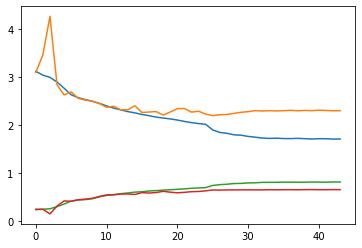

In [120]:
plt.plot(hist)

In [122]:
model = torch.load('newexp_new/svgg_cosinesims_logloss_model.pt')
exp_features = []
exp_labels = []
_sims = []
_sims_labels = []

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, sims, sims_labels, features, sims_loss = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())
        _sims.append(sims.detach().cpu())
        _sims_labels.append(sims_labels.detach().cpu())

    sims_loss = sims_criterion(sims, sims_labels)
    loss = criterion(outputs, labels) + sims_loss
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. test_loss: 1.5085 | Avg. test_acc: 0.6790


In [123]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[-20.521767  ,  45.991535  ],
        [ -2.1013722 ,  -0.62947273],
        [ -5.684032  ,  12.278372  ],
        ...,
        [ -7.0539174 ,  26.245977  ],
        [  9.074737  , -22.040531  ],
        [-31.91837   ,  26.550823  ]], dtype=float32))

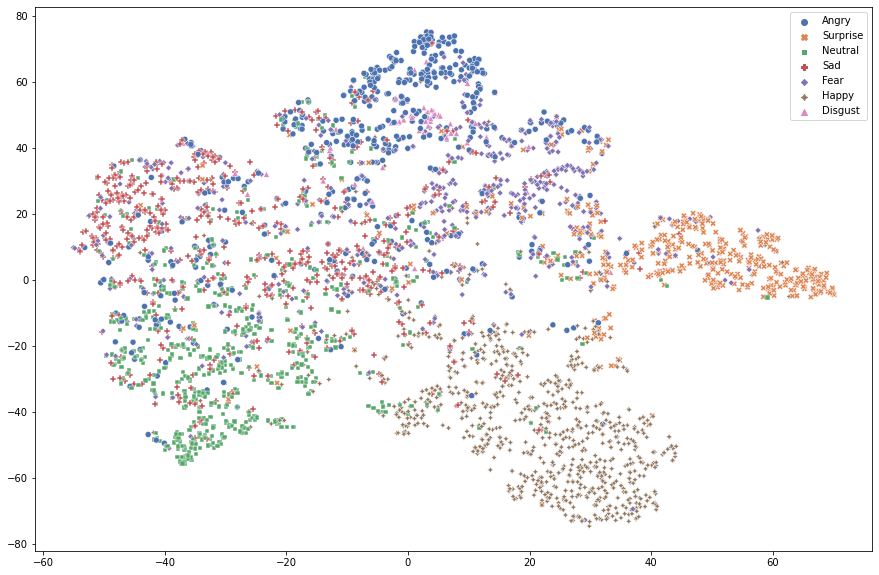

In [124]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)